In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt

from statsmodels.tools.eval_measures import rmse
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout  
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [8]:
train = pd.read_csv('datasets/podzielone/ml/wszystkie/train_ml.csv', index_col=0)
val1 = pd.read_csv('datasets/podzielone/ml/wszystkie/valid1_ml.csv', index_col=0)
val2 = pd.read_csv('datasets/podzielone/ml/wszystkie/valid2_ml.csv', index_col=0)
val3 = pd.read_csv('datasets/podzielone/ml/wszystkie/valid3_ml.csv', index_col=0)
test = pd.read_csv('datasets/podzielone/ml/wszystkie/test_ml.csv', index_col=0)




train.index = pd.to_datetime(train.index)
val1.index = pd.to_datetime(val1.index)
val2.index = pd.to_datetime(val2.index)
val3.index = pd.to_datetime(val3.index)
test.index = pd.to_datetime(test.index)


train["day_of_week"] = train.index.dayofweek
train["day_of_year"] = train.index.dayofweek
train["week"] = train.index.week
train["quarter"] = train.index.quarter
train["return_ratio"] = train.y_return_ratio.shift()

val1["day_of_week"] = val1.index.dayofweek
val1["day_of_year"] = val1.index.dayofweek
val1["week"] = val1.index.week
val1["quarter"] = val1.index.quarter
val1["return_ratio"] = val1.y_return_ratio.shift()

val2["day_of_week"] = val2.index.dayofweek
val2["day_of_year"] = val2.index.dayofweek
val2["week"] = val2.index.week
val2["quarter"] = val2.index.quarter
val2["return_ratio"] = val2.y_return_ratio.shift()

val3["day_of_week"] = val3.index.dayofweek
val3["day_of_year"] = val3.index.dayofweek
val3["week"] = val3.index.week
val3["quarter"] = val3.index.quarter
val3["return_ratio"] = val3.y_return_ratio.shift()

test["day_of_week"] = test.index.dayofweek
test["day_of_year"] = test.index.dayofweek
test["week"] = test.index.week
test["quarter"] = test.index.quarter
test["return_ratio"] = test.y_return_ratio.shift()

train.columns=train.columns.str.replace('(','')
train.columns=train.columns.str.replace(']','')

val1.columns=val1.columns.str.replace('(','')
val1.columns=val1.columns.str.replace(']','')
val2.columns=val2.columns.str.replace('(','')
val2.columns=val2.columns.str.replace(']','')
val3.columns=val3.columns.str.replace('(','')
val3.columns=val3.columns.str.replace(']','')


test.columns=test.columns.str.replace('(','')
test.columns=test.columns.str.replace(']','')

whole = pd.concat([train, val1, val2, val3, test]).asfreq('B', method='bfill').fillna(method='bfill')
val = pd.concat([val1, val2, val3]).asfreq('B', method='bfill').fillna(method='bfill')


val.columns=val.columns.str.replace('(','')
val.columns=val.columns.str.replace(']','')

train1 = train.asfreq('B', method='bfill').fillna(method='bfill')
train2 = pd.concat([train, val1]).asfreq('B', method='bfill').fillna(method='bfill')
train3 = pd.concat([train, val1, val2]).asfreq('B', method='bfill').fillna(method='bfill')

val1 = val1.asfreq('B', method='bfill').fillna(method='bfill')
val2 = val2.asfreq('B', method='bfill').fillna(method='bfill')
val3 = val3.asfreq('B', method='bfill').fillna(method='bfill')
test = test.asfreq('B', method='bfill').fillna(method='bfill')



display(train.head(3))
display(val1.head(3))
display(val2.head(3))
display(val3.head(3))
display(test.head(3))
display(whole.head(3))

,y_return_ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,...,ATAN_diff_1,CEIL_diff_1,FLOOR_diff_1,LN_diff_1,LOG10_diff_1,SQRT_diff_1,day_of_week,day_of_year,week,quarter
2012-07-02,-0.026773,0.475985,1.53,148.118434,12.781515,62.987843,-1.546392,59.313104,31.365741,2.350220,...,0.003153,0.0,0.0,0.042874,0.018620,0.078845,0,0,27,3
2012-07-03,0.026022,0.481986,1.05,103.024634,12.824644,57.664648,-22.613065,52.602204,23.907183,2.182347,...,-0.001980,0.0,0.0,-0.027138,-0.011786,-0.050102,1,1,27,3
2012-07-05,-0.010145,0.475416,0.56,110.859729,12.887570,61.020501,-5.025126,57.027455,23.907183,2.026465,...,0.001876,0.0,0.0,0.025689,0.011157,0.047411,3,3,27,3


,y_return_ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,...,ATAN_diff_1,CEIL_diff_1,FLOOR_diff_1,LN_diff_1,LOG10_diff_1,SQRT_diff_1,day_of_week,day_of_year,week,quarter
2018-01-02,0.030233,5.125354,7.029999,27.231458,196.912948,45.133485,-42.095010,55.894280,23.134279,13.144963,...,-0.000102,-4.0,-4.0,-0.019955,-0.008666,-0.139483,1,1,1,1
2018-01-03,0.065814,5.187829,7.790008,77.718696,197.070178,53.249819,-4.033801,55.819341,19.229973,13.246030,...,0.000152,6.0,6.0,0.029785,0.012935,0.208708,2,2,1,1
2018-01-04,0.005271,5.842269,14.570007,279.927608,198.063715,65.556102,-4.226792,67.077304,18.683056,26.499882,...,0.000310,13.0,13.0,0.063739,0.027681,0.457215,3,3,1,1


,y_return_ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,...,ATAN_diff_1,CEIL_diff_1,FLOOR_diff_1,LN_diff_1,LOG10_diff_1,SQRT_diff_1,day_of_week,day_of_year,week,quarter
2018-03-01,-0.040455,8.425720,9.369995,37.127358,234.729083,54.963241,-28.932093,70.942953,2.299899,24.419310,...,-0.000068,-5.0,-4.0,-0.016638,-0.007226,-0.129951,3,3,9,1
2018-03-02,0.018647,8.964597,-9.209991,-67.945451,234.566562,47.416343,-57.358478,71.264678,24.198760,22.675074,...,-0.000174,-9.0,-10.0,-0.041296,-0.017934,-0.317911,4,4,9,1
2018-03-05,-0.003763,9.392126,-9.960007,-108.267191,234.693880,50.644262,-51.228455,60.063802,31.886239,21.055426,...,0.000079,4.0,4.0,0.018475,0.008024,0.141418,0,0,10,1


,y_return_ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,...,ATAN_diff_1,CEIL_diff_1,FLOOR_diff_1,LN_diff_1,LOG10_diff_1,SQRT_diff_1,day_of_week,day_of_year,week,quarter
2018-05-01,0.009960,8.606211,-6.590011,-36.196616,229.129258,46.714722,-49.568247,52.298305,16.163336,22.665165,...,-0.000028,-2.0,-2.0,-0.006338,-0.002753,-0.047602,1,1,18,2
2018-05-02,-0.003654,8.352196,-10.399994,-41.609464,229.000918,48.681141,-41.830750,46.410723,19.251258,21.046224,...,0.000044,3.0,3.0,0.009911,0.004304,0.074498,2,2,18,2
2018-05-03,0.029517,8.009182,-10.059997,-16.440286,228.827311,47.974668,-44.697766,43.162233,15.551078,21.092926,...,-0.000016,-1.0,-1.0,-0.003661,-0.001590,-0.027561,3,3,18,2


,y_return_ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,...,ATAN_diff_1,CEIL_diff_1,FLOOR_diff_1,LN_diff_1,LOG10_diff_1,SQRT_diff_1,day_of_week,day_of_year,week,quarter
2018-07-02,0.022541,6.899792,-28.360016,-97.965938,250.580128,36.289331,-94.472074,39.345807,40.019379,13.617902,...,-0.000069,-4.0,-4.0,-0.016578,-0.007200,-0.128109,0,0,27,3
2018-07-03,-0.022292,7.059093,-22.849991,-81.994860,250.042056,42.388575,-75.013896,39.426792,44.725629,12.645195,...,0.000093,6.0,6.0,0.022291,0.009681,0.172505,1,1,27,3
2018-07-04,0.024869,7.082015,-23.330017,-71.397983,249.190310,38.386549,-90.038956,34.350825,39.822012,13.231972,...,-0.000094,-6.0,-6.0,-0.022544,-0.009791,-0.174455,3,3,27,3


,y_return_ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,...,ATAN_diff_1,CEIL_diff_1,FLOOR_diff_1,LN_diff_1,LOG10_diff_1,SQRT_diff_1,day_of_week,day_of_year,week,quarter
2012-07-02,-0.026773,0.475985,1.53,148.118434,12.781515,62.987843,-1.546392,59.313104,31.365741,2.350220,...,0.003153,0.0,0.0,0.042874,0.018620,0.078845,0,0,27,3
2012-07-03,0.026022,0.481986,1.05,103.024634,12.824644,57.664648,-22.613065,52.602204,23.907183,2.182347,...,-0.001980,0.0,0.0,-0.027138,-0.011786,-0.050102,1,1,27,3
2012-07-04,-0.010145,0.475416,0.56,110.859729,12.887570,61.020501,-5.025126,57.027455,23.907183,2.026465,...,0.001876,0.0,0.0,0.025689,0.011157,0.047411,3,3,27,3


In [9]:
S = [(train1, val1), (train2, val2), (train3, val3)]

In [10]:
variables = train.columns.tolist()
variables.remove("y_return_ratio")
features = train[variables].columns
target = 'y_return_ratio'

# Korelacje Spearmana

In [11]:
corr_matrix = whole.drop(columns=['y_return_ratio']).corr("spearman").abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

var1 = [col for col in upper.columns if upper[col].max() < 0.9]
var2 = [col for col in upper.columns if upper[col].max() < 0.7]
var3 = [col for col in upper.columns if upper[col].max() < 0.5]
var4 = [col for col in upper.columns if upper[col].max() < 0.4]
var5 = [col for col in upper.columns if upper[col].max() < 0.3]

print(len(var1))
print(len(var2))
print(len(var3))
print(len(var4))

print(len(var5))

191
128
100
78
57


# ExtraTreesRegression

In [12]:
X_train1 = train1[var5]
y_train1 = train1[target]
X_test1 = val[var5]
y_test1 = val[target]

model = ExtraTreesRegressor()
model.fit(X_train1, y_train1)
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train1.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,importance
TAN,8.280293e-02
MOM,7.036863e-02
ATVI_gaming_rr,6.274122e-02
BETA,5.890587e-02
UBSFY_gaming_rolling_variance,5.602033e-02
day_of_week,5.134120e-02
inventory_turnover_ratio,4.893695e-02
SIN,4.682126e-02
return_ratio_shift_7,4.580275e-02
UBSFY_gaming_rr,4.418854e-02


# LSTM

Instructions for updating:
Colocations handled automatically by placer.


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Instructions for updating:
Use tf.cast instead.
Train on 1135 samples, validate on 300 samples
Epoch 1/3
1135/1135 [==============================] - 1s 736us/step - loss: 0.1550 - val_loss: 0.1422
Epoch 2/3
1135/1135 [==============================] - 0s 147us/step - loss: 0.0764 - val_loss: 0.0936
Epoch 3/3
1135/1135 [==============================] - 0s 118us/step - loss: 0.0649 - val_loss: 0.0935


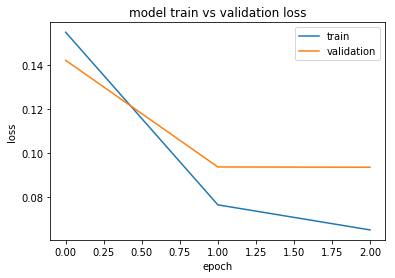

[-0.0045807813]
0 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1137 samples, validate on 300 samples
Epoch 1/3
1137/1137 [==============================] - 1s 768us/step - loss: 0.8753 - val_loss: 0.4438
Epoch 2/3
1137/1137 [==============================] - 0s 87us/step - loss: 0.1967 - val_loss: 0.1717
Epoch 3/3
1137/1137 [==============================] - 0s 92us/step - loss: 0.1349 - val_loss: 0.0900


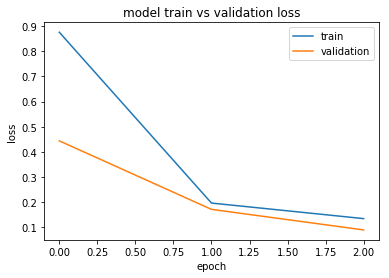

[-0.0045807813, -0.0014651576]
1 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1138 samples, validate on 300 samples
Epoch 1/3
1138/1138 [==============================] - 1s 809us/step - loss: 0.9599 - val_loss: 0.5079
Epoch 2/3
1138/1138 [==============================] - 0s 106us/step - loss: 0.2317 - val_loss: 0.1801
Epoch 3/3
1138/1138 [==============================] - 0s 91us/step - loss: 0.1427 - val_loss: 0.0983


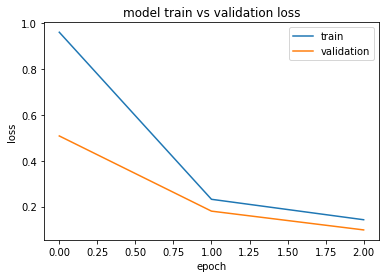

[-0.0045807813, -0.0014651576, 0.011698445]
2 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1139 samples, validate on 300 samples
Epoch 1/3
1139/1139 [==============================] - 1s 901us/step - loss: 0.2643 - val_loss: 0.1345
Epoch 2/3
1139/1139 [==============================] - 0s 94us/step - loss: 0.1008 - val_loss: 0.1053
Epoch 3/3
1139/1139 [==============================] - 0s 93us/step - loss: 0.0674 - val_loss: 0.0887


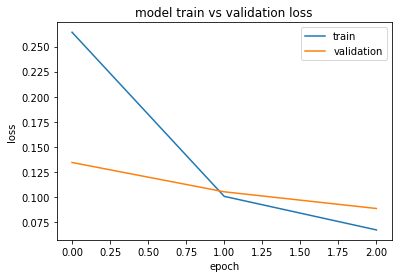

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683]
3 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1140 samples, validate on 300 samples
Epoch 1/3
1140/1140 [==============================] - 1s 1ms/step - loss: 0.3002 - val_loss: 0.0918
Epoch 2/3
1140/1140 [==============================] - 0s 85us/step - loss: 0.1079 - val_loss: 0.0522
Epoch 3/3
1140/1140 [==============================] - 0s 103us/step - loss: 0.0560 - val_loss: 0.0515


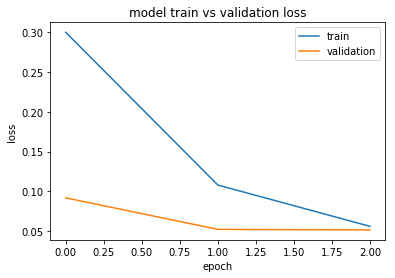

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058]
4 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1141 samples, validate on 300 samples
Epoch 1/3
1141/1141 [==============================] - 1s 1ms/step - loss: 0.0445 - val_loss: 0.0609
Epoch 2/3
1141/1141 [==============================] - 0s 85us/step - loss: 0.0397 - val_loss: 0.0491
Epoch 3/3
1141/1141 [==============================] - 0s 115us/step - loss: 0.0355 - val_loss: 0.0517


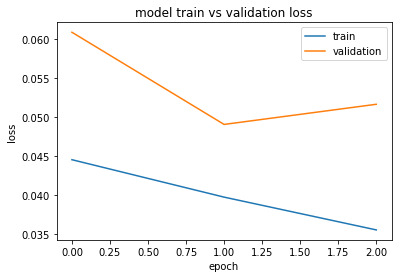

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487]
5 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1142 samples, validate on 300 samples
Epoch 1/3
1142/1142 [==============================] - 1s 1ms/step - loss: 0.6599 - val_loss: 0.3344
Epoch 2/3
1142/1142 [==============================] - 0s 98us/step - loss: 0.1525 - val_loss: 0.1152
Epoch 3/3
1142/1142 [==============================] - 0s 98us/step - loss: 0.0916 - val_loss: 0.0559


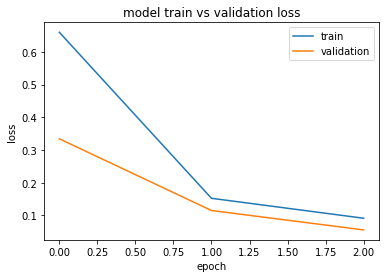

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707]
6 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1143 samples, validate on 300 samples
Epoch 1/3
1143/1143 [==============================] - 2s 1ms/step - loss: 0.5417 - val_loss: 0.1385
Epoch 2/3
1143/1143 [==============================] - 0s 93us/step - loss: 0.1183 - val_loss: 0.1228
Epoch 3/3
1143/1143 [==============================] - 0s 98us/step - loss: 0.0673 - val_loss: 0.0764


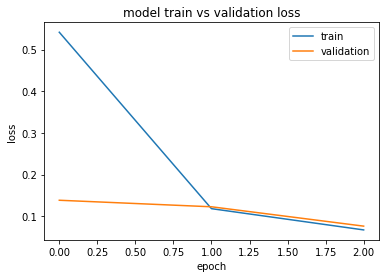

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887]
7 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1144 samples, validate on 300 samples
Epoch 1/3
1144/1144 [==============================] - 2s 2ms/step - loss: 0.1102 - val_loss: 0.0505
Epoch 2/3
1144/1144 [==============================] - 0s 113us/step - loss: 0.0519 - val_loss: 0.0674
Epoch 3/3
1144/1144 [==============================] - 0s 93us/step - loss: 0.0441 - val_loss: 0.0482


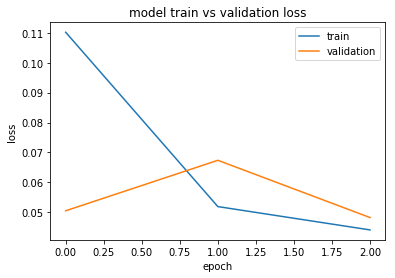

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064]
8 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1145 samples, validate on 300 samples
Epoch 1/3
1145/1145 [==============================] - 2s 2ms/step - loss: 0.3172 - val_loss: 0.0925
Epoch 2/3
1145/1145 [==============================] - 0s 109us/step - loss: 0.1010 - val_loss: 0.0618
Epoch 3/3
1145/1145 [==============================] - 0s 116us/step - loss: 0.0595 - val_loss: 0.0578


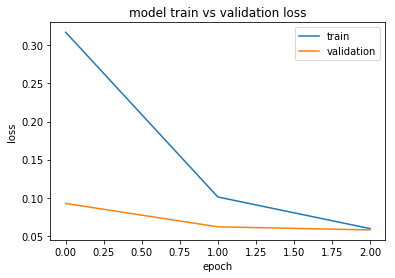

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967]
9 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1146 samples, validate on 300 samples
Epoch 1/3
1146/1146 [==============================] - 2s 2ms/step - loss: 0.0698 - val_loss: 0.0585
Epoch 2/3
1146/1146 [==============================] - 0s 102us/step - loss: 0.0457 - val_loss: 0.0500
Epoch 3/3
1146/1146 [==============================] - 0s 98us/step - loss: 0.0393 - val_loss: 0.0517


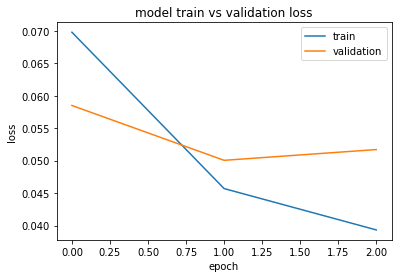

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798]
10 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1147 samples, validate on 300 samples
Epoch 1/3
1147/1147 [==============================] - 2s 2ms/step - loss: 0.0822 - val_loss: 0.0689
Epoch 2/3
1147/1147 [==============================] - 0s 103us/step - loss: 0.0514 - val_loss: 0.0539
Epoch 3/3
1147/1147 [==============================] - 0s 102us/step - loss: 0.0401 - val_loss: 0.0521


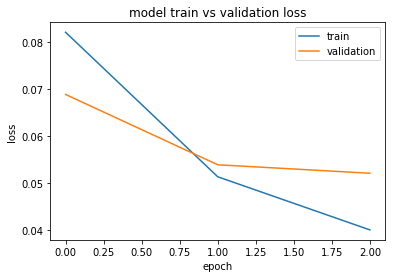

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631]
11 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1148 samples, validate on 300 samples
Epoch 1/3
1148/1148 [==============================] - 2s 2ms/step - loss: 1.1101 - val_loss: 0.6488
Epoch 2/3
1148/1148 [==============================] - 0s 86us/step - loss: 0.3400 - val_loss: 0.1027
Epoch 3/3
1148/1148 [==============================] - 0s 112us/step - loss: 0.1350 - val_loss: 0.0638


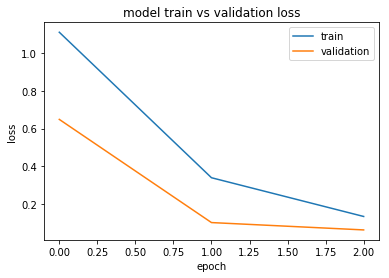

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427]
12 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1149 samples, validate on 300 samples
Epoch 1/3
1149/1149 [==============================] - 2s 2ms/step - loss: 0.2052 - val_loss: 0.1350
Epoch 2/3
1149/1149 [==============================] - 0s 145us/step - loss: 0.0755 - val_loss: 0.0662
Epoch 3/3
1149/1149 [==============================] - 0s 108us/step - loss: 0.0466 - val_loss: 0.0531


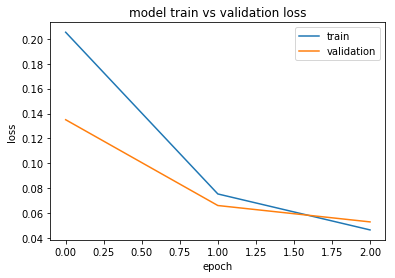

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475]
13 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1150 samples, validate on 300 samples
Epoch 1/3
1150/1150 [==============================] - 3s 2ms/step - loss: 0.0436 - val_loss: 0.0533
Epoch 2/3
1150/1150 [==============================] - 0s 120us/step - loss: 0.0394 - val_loss: 0.0498
Epoch 3/3
1150/1150 [==============================] - 0s 102us/step - loss: 0.0368 - val_loss: 0.0493


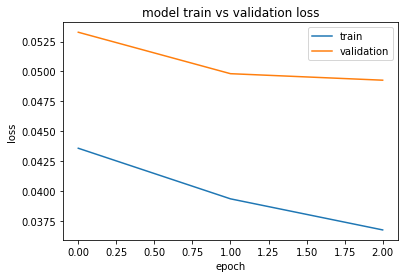

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254]
14 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1151 samples, validate on 300 samples
Epoch 1/3
1151/1151 [==============================] - 3s 2ms/step - loss: 0.3569 - val_loss: 0.0554
Epoch 2/3
1151/1151 [==============================] - 0s 114us/step - loss: 0.0873 - val_loss: 0.0779
Epoch 3/3
1151/1151 [==============================] - 0s 94us/step - loss: 0.0495 - val_loss: 0.0527


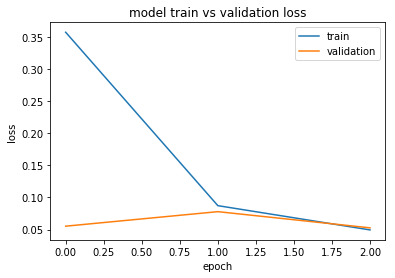

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812]
15 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1152 samples, validate on 300 samples
Epoch 1/3
1152/1152 [==============================] - 3s 2ms/step - loss: 0.1136 - val_loss: 0.0598
Epoch 2/3
1152/1152 [==============================] - 0s 107us/step - loss: 0.0551 - val_loss: 0.0584
Epoch 3/3
1152/1152 [==============================] - 0s 127us/step - loss: 0.0465 - val_loss: 0.0566


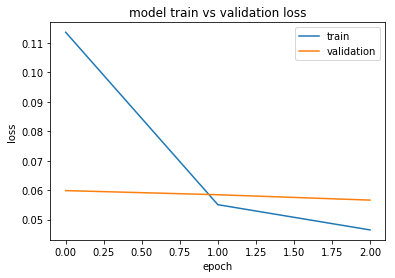

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235]
16 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1153 samples, validate on 300 samples
Epoch 1/3
1153/1153 [==============================] - 3s 3ms/step - loss: 0.4491 - val_loss: 0.0531
Epoch 2/3
1153/1153 [==============================] - 0s 93us/step - loss: 0.1210 - val_loss: 0.0498
Epoch 3/3
1153/1153 [==============================] - 0s 88us/step - loss: 0.0586 - val_loss: 0.0541


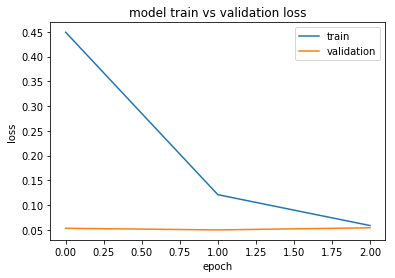

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773]
17 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1154 samples, validate on 300 samples
Epoch 1/3
1154/1154 [==============================] - 3s 3ms/step - loss: 0.0895 - val_loss: 0.0582
Epoch 2/3
1154/1154 [==============================] - 0s 92us/step - loss: 0.0551 - val_loss: 0.0613
Epoch 3/3
1154/1154 [==============================] - 0s 86us/step - loss: 0.0444 - val_loss: 0.0534


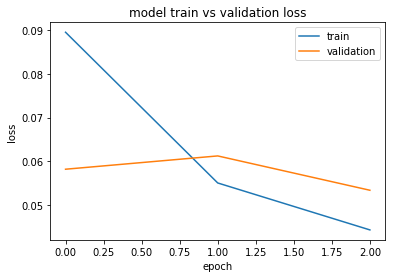

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216]
18 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1155 samples, validate on 300 samples
Epoch 1/3
1155/1155 [==============================] - 3s 3ms/step - loss: 0.1504 - val_loss: 0.1117
Epoch 2/3
1155/1155 [==============================] - 0s 94us/step - loss: 0.0618 - val_loss: 0.0518
Epoch 3/3
1155/1155 [==============================] - 0s 89us/step - loss: 0.0449 - val_loss: 0.0495


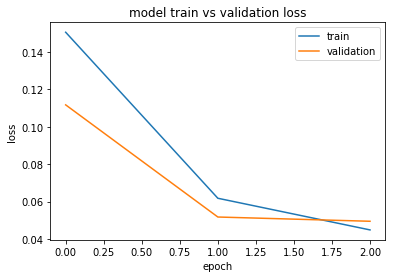

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011]
19 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1156 samples, validate on 300 samples
Epoch 1/3
1156/1156 [==============================] - 3s 3ms/step - loss: 0.6089 - val_loss: 0.1325
Epoch 2/3
1156/1156 [==============================] - 0s 90us/step - loss: 0.1302 - val_loss: 0.1298
Epoch 3/3
1156/1156 [==============================] - 0s 89us/step - loss: 0.0784 - val_loss: 0.0841


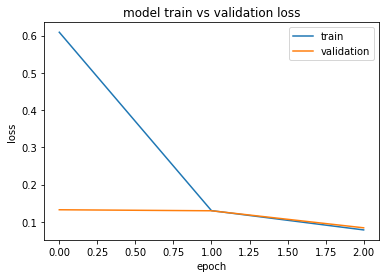

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261]
20 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1157 samples, validate on 300 samples
Epoch 1/3
1157/1157 [==============================] - 3s 3ms/step - loss: 0.6126 - val_loss: 0.1848
Epoch 2/3
1157/1157 [==============================] - 0s 88us/step - loss: 0.1173 - val_loss: 0.1169
Epoch 3/3
1157/1157 [==============================] - 0s 88us/step - loss: 0.0661 - val_loss: 0.0735


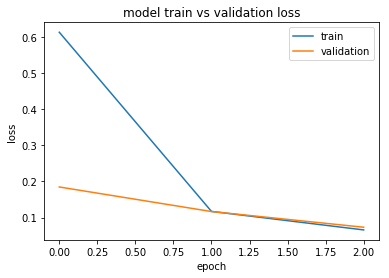

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505]
21 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1158 samples, validate on 300 samples
Epoch 1/3
1158/1158 [==============================] - 4s 3ms/step - loss: 0.5737 - val_loss: 0.1517
Epoch 2/3
1158/1158 [==============================] - 0s 93us/step - loss: 0.1104 - val_loss: 0.1160
Epoch 3/3
1158/1158 [==============================] - 0s 96us/step - loss: 0.0695 - val_loss: 0.0796


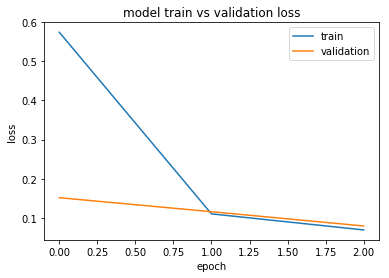

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986]
22 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1159 samples, validate on 300 samples
Epoch 1/3
1159/1159 [==============================] - 4s 3ms/step - loss: 0.1122 - val_loss: 0.0493
Epoch 2/3
1159/1159 [==============================] - 0s 94us/step - loss: 0.0493 - val_loss: 0.0555
Epoch 3/3
1159/1159 [==============================] - 0s 96us/step - loss: 0.0418 - val_loss: 0.0484


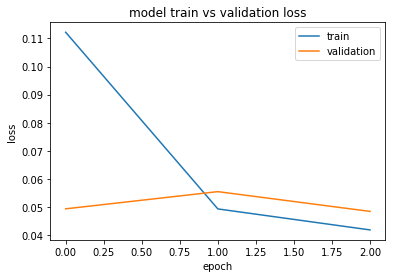

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398]
23 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1160 samples, validate on 300 samples
Epoch 1/3
1160/1160 [==============================] - 4s 3ms/step - loss: 0.5257 - val_loss: 0.1823
Epoch 2/3
1160/1160 [==============================] - 0s 87us/step - loss: 0.1090 - val_loss: 0.1385
Epoch 3/3
1160/1160 [==============================] - 0s 91us/step - loss: 0.0765 - val_loss: 0.0714


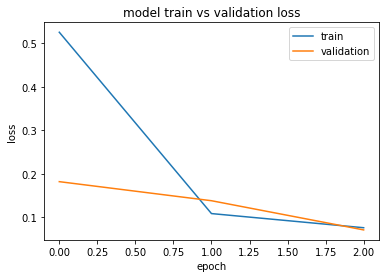

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188]
24 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1161 samples, validate on 300 samples
Epoch 1/3
1161/1161 [==============================] - 4s 3ms/step - loss: 0.0645 - val_loss: 0.0704
Epoch 2/3
1161/1161 [==============================] - 0s 89us/step - loss: 0.0455 - val_loss: 0.0547
Epoch 3/3
1161/1161 [==============================] - 0s 89us/step - loss: 0.0367 - val_loss: 0.0490


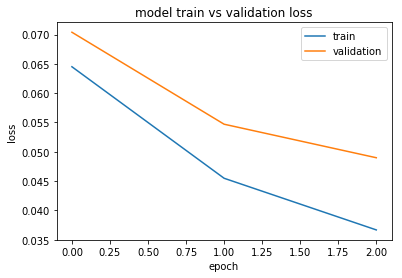

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716]
25 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1162 samples, validate on 300 samples
Epoch 1/3
1162/1162 [==============================] - 4s 3ms/step - loss: 0.2174 - val_loss: 0.1432
Epoch 2/3
1162/1162 [==============================] - 0s 95us/step - loss: 0.0838 - val_loss: 0.0682
Epoch 3/3
1162/1162 [==============================] - 0s 100us/step - loss: 0.0504 - val_loss: 0.0670


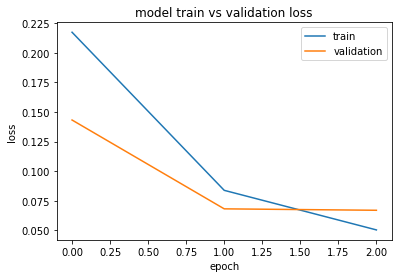

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646]
26 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1163 samples, validate on 300 samples
Epoch 1/3
1163/1163 [==============================] - 4s 4ms/step - loss: 0.1445 - val_loss: 0.1104
Epoch 2/3
1163/1163 [==============================] - 0s 122us/step - loss: 0.0595 - val_loss: 0.0528
Epoch 3/3
1163/1163 [==============================] - 0s 105us/step - loss: 0.0432 - val_loss: 0.0489


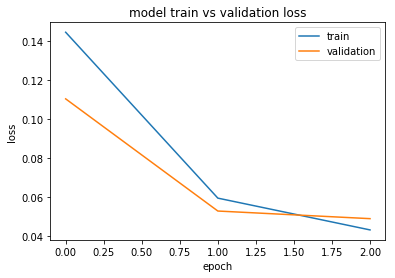

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832]
27 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1164 samples, validate on 300 samples
Epoch 1/3
1164/1164 [==============================] - 4s 4ms/step - loss: 0.1591 - val_loss: 0.1067
Epoch 2/3
1164/1164 [==============================] - 0s 100us/step - loss: 0.0630 - val_loss: 0.0520
Epoch 3/3
1164/1164 [==============================] - 0s 91us/step - loss: 0.0396 - val_loss: 0.0494


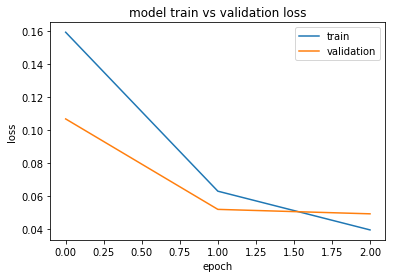

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901]
28 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1165 samples, validate on 300 samples
Epoch 1/3
1165/1165 [==============================] - 4s 4ms/step - loss: 0.8312 - val_loss: 0.4859
Epoch 2/3
1165/1165 [==============================] - 0s 97us/step - loss: 0.2694 - val_loss: 0.0570
Epoch 3/3
1165/1165 [==============================] - 0s 97us/step - loss: 0.1125 - val_loss: 0.0835


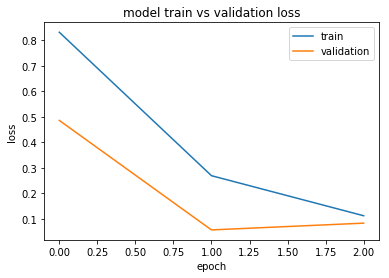

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244]
29 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1166 samples, validate on 300 samples
Epoch 1/3
1166/1166 [==============================] - 5s 4ms/step - loss: 0.2338 - val_loss: 0.1432
Epoch 2/3
1166/1166 [==============================] - 0s 91us/step - loss: 0.0825 - val_loss: 0.0758
Epoch 3/3
1166/1166 [==============================] - 0s 95us/step - loss: 0.0495 - val_loss: 0.0556


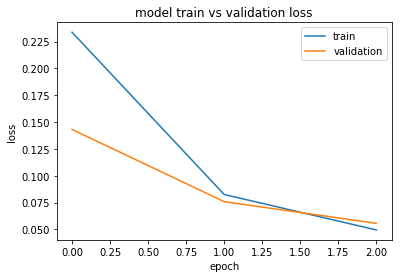

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197]
30 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1167 samples, validate on 300 samples
Epoch 1/3
1167/1167 [==============================] - 5s 4ms/step - loss: 0.0408 - val_loss: 0.0496
Epoch 2/3
1167/1167 [==============================] - 0s 95us/step - loss: 0.0367 - val_loss: 0.0509
Epoch 3/3
1167/1167 [==============================] - 0s 90us/step - loss: 0.0365 - val_loss: 0.0515


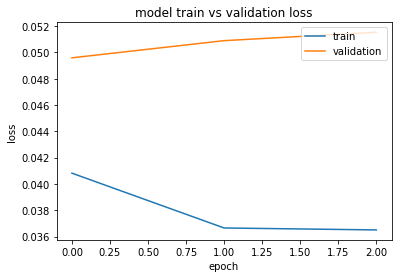

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167]
31 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1168 samples, validate on 300 samples
Epoch 1/3
1168/1168 [==============================] - 5s 4ms/step - loss: 0.1292 - val_loss: 0.0846
Epoch 2/3
1168/1168 [==============================] - 0s 91us/step - loss: 0.0530 - val_loss: 0.0553
Epoch 3/3
1168/1168 [==============================] - 0s 91us/step - loss: 0.0436 - val_loss: 0.0535


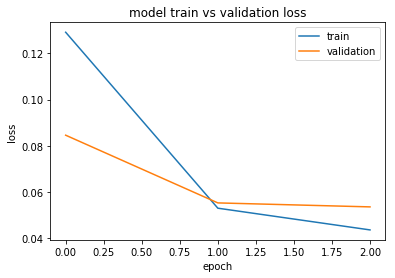

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016]
32 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1169 samples, validate on 300 samples
Epoch 1/3
1169/1169 [==============================] - 5s 4ms/step - loss: 0.7232 - val_loss: 0.3771
Epoch 2/3
1169/1169 [==============================] - 0s 94us/step - loss: 0.1733 - val_loss: 0.1205
Epoch 3/3
1169/1169 [==============================] - 0s 88us/step - loss: 0.1037 - val_loss: 0.0554


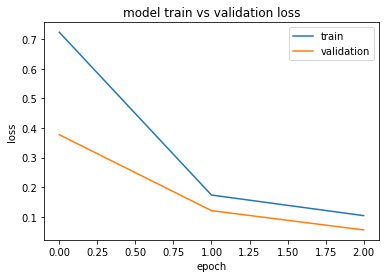

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628]
33 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1170 samples, validate on 300 samples
Epoch 1/3
1170/1170 [==============================] - 5s 4ms/step - loss: 0.0730 - val_loss: 0.0729
Epoch 2/3
1170/1170 [==============================] - 0s 84us/step - loss: 0.0479 - val_loss: 0.0510
Epoch 3/3
1170/1170 [==============================] - 0s 81us/step - loss: 0.0386 - val_loss: 0.0513


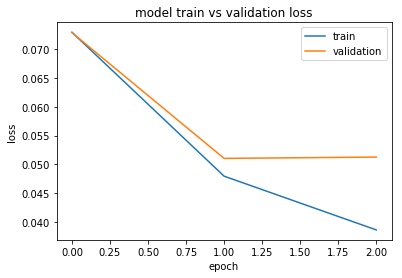

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982]
34 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1171 samples, validate on 300 samples
Epoch 1/3
1171/1171 [==============================] - 6s 5ms/step - loss: 1.1357 - val_loss: 0.7392
Epoch 2/3
1171/1171 [==============================] - 0s 95us/step - loss: 0.5125 - val_loss: 0.1967
Epoch 3/3
1171/1171 [==============================] - 0s 96us/step - loss: 0.1030 - val_loss: 0.1429


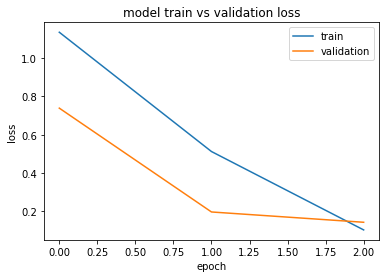

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105]
35 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1172 samples, validate on 300 samples
Epoch 1/3
1172/1172 [==============================] - 6s 5ms/step - loss: 0.2511 - val_loss: 0.1262
Epoch 2/3
1172/1172 [==============================] - 0s 93us/step - loss: 0.0861 - val_loss: 0.0843
Epoch 3/3
1172/1172 [==============================] - 0s 97us/step - loss: 0.0506 - val_loss: 0.0513


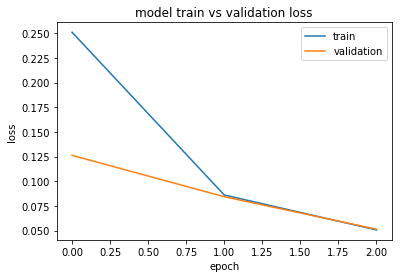

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579]
36 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1173 samples, validate on 300 samples
Epoch 1/3
1173/1173 [==============================] - 6s 5ms/step - loss: 0.0471 - val_loss: 0.0584
Epoch 2/3
1173/1173 [==============================] - 0s 95us/step - loss: 0.0429 - val_loss: 0.0498
Epoch 3/3
1173/1173 [==============================] - 0s 96us/step - loss: 0.0378 - val_loss: 0.0494


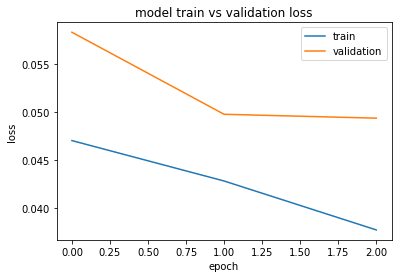

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787]
37 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1174 samples, validate on 300 samples
Epoch 1/3
1174/1174 [==============================] - 6s 5ms/step - loss: 0.2599 - val_loss: 0.1368
Epoch 2/3
1174/1174 [==============================] - 0s 93us/step - loss: 0.0897 - val_loss: 0.0709
Epoch 3/3
1174/1174 [==============================] - 0s 96us/step - loss: 0.0558 - val_loss: 0.0666


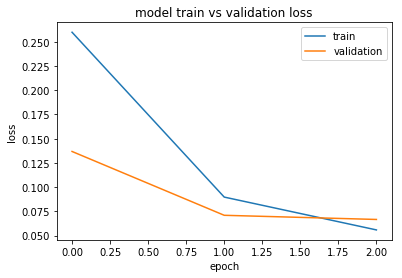

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532]
38 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1175 samples, validate on 300 samples
Epoch 1/3
1175/1175 [==============================] - 6s 5ms/step - loss: 0.0427 - val_loss: 0.0482
Epoch 2/3
1175/1175 [==============================] - 0s 98us/step - loss: 0.0370 - val_loss: 0.0486
Epoch 3/3
1175/1175 [==============================] - 0s 96us/step - loss: 0.0362 - val_loss: 0.0486


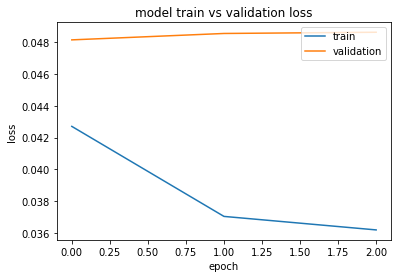

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185]
39 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1176 samples, validate on 300 samples
Epoch 1/3
1176/1176 [==============================] - 6s 5ms/step - loss: 0.0626 - val_loss: 0.0602
Epoch 2/3
1176/1176 [==============================] - 0s 96us/step - loss: 0.0410 - val_loss: 0.0527
Epoch 3/3
1176/1176 [==============================] - 0s 103us/step - loss: 0.0374 - val_loss: 0.0488


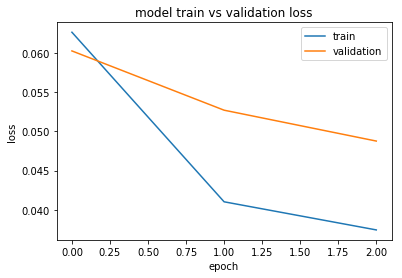

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695]
40 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1177 samples, validate on 300 samples
Epoch 1/3
1177/1177 [==============================] - 6s 5ms/step - loss: 0.1418 - val_loss: 0.0787
Epoch 2/3
1177/1177 [==============================] - 0s 144us/step - loss: 0.0592 - val_loss: 0.0550
Epoch 3/3
1177/1177 [==============================] - 0s 133us/step - loss: 0.0481 - val_loss: 0.0596


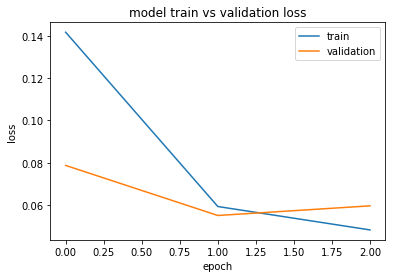

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633]
41 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1178 samples, validate on 300 samples
Epoch 1/3
1178/1178 [==============================] - 7s 6ms/step - loss: 0.0816 - val_loss: 0.0522
Epoch 2/3
1178/1178 [==============================] - 0s 103us/step - loss: 0.0476 - val_loss: 0.0565
Epoch 3/3
1178/1178 [==============================] - 0s 88us/step - loss: 0.0385 - val_loss: 0.0497


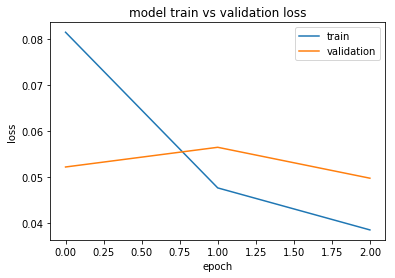

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834]
42 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1179 samples, validate on 300 samples
Epoch 1/3
1179/1179 [==============================] - 7s 6ms/step - loss: 0.3433 - val_loss: 0.1413
Epoch 2/3
1179/1179 [==============================] - 0s 91us/step - loss: 0.1108 - val_loss: 0.0828
Epoch 3/3
1179/1179 [==============================] - 0s 101us/step - loss: 0.0579 - val_loss: 0.0577


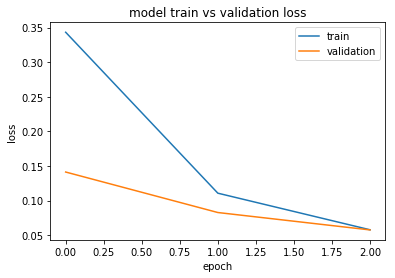

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298]
43 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1180 samples, validate on 300 samples
Epoch 1/3
1180/1180 [==============================] - 8s 7ms/step - loss: 0.5836 - val_loss: 0.2121
Epoch 2/3
1180/1180 [==============================] - 0s 82us/step - loss: 0.1223 - val_loss: 0.1485
Epoch 3/3
1180/1180 [==============================] - 0s 88us/step - loss: 0.0820 - val_loss: 0.0822


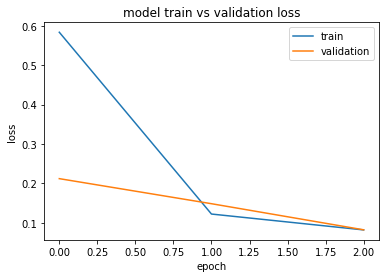

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848]
44 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1181 samples, validate on 300 samples
Epoch 1/3
1181/1181 [==============================] - 7s 6ms/step - loss: 0.0544 - val_loss: 0.0496
Epoch 2/3
1181/1181 [==============================] - 0s 96us/step - loss: 0.0391 - val_loss: 0.0490
Epoch 3/3
1181/1181 [==============================] - 0s 106us/step - loss: 0.0397 - val_loss: 0.0475


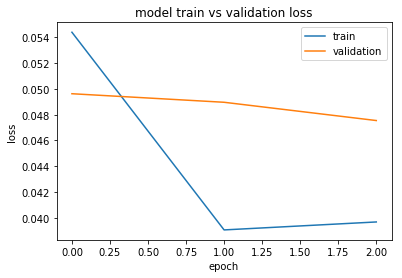

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707]
45 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1182 samples, validate on 300 samples
Epoch 1/3
1182/1182 [==============================] - 7s 6ms/step - loss: 0.0975 - val_loss: 0.0602
Epoch 2/3
1182/1182 [==============================] - 0s 100us/step - loss: 0.0573 - val_loss: 0.0656
Epoch 3/3
1182/1182 [==============================] - 0s 100us/step - loss: 0.0420 - val_loss: 0.0478


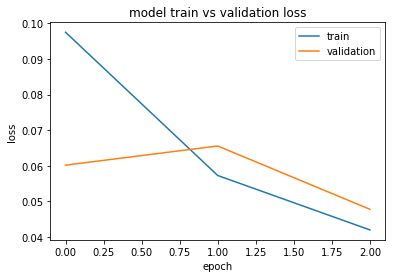

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977]
46 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1183 samples, validate on 300 samples
Epoch 1/3
1183/1183 [==============================] - 7s 6ms/step - loss: 0.0602 - val_loss: 0.0502
Epoch 2/3
1183/1183 [==============================] - 0s 94us/step - loss: 0.0414 - val_loss: 0.0517
Epoch 3/3
1183/1183 [==============================] - 0s 92us/step - loss: 0.0392 - val_loss: 0.0524


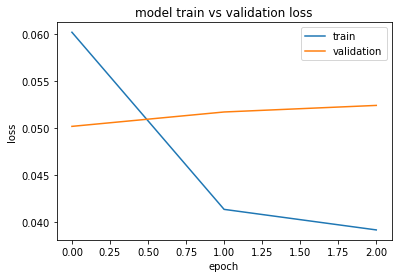

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806]
47 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1184 samples, validate on 300 samples
Epoch 1/3
1184/1184 [==============================] - 8s 6ms/step - loss: 0.4062 - val_loss: 0.0596
Epoch 2/3
1184/1184 [==============================] - 0s 97us/step - loss: 0.1058 - val_loss: 0.0517
Epoch 3/3
1184/1184 [==============================] - 0s 96us/step - loss: 0.0559 - val_loss: 0.0537


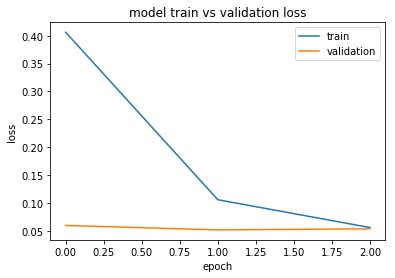

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918]
48 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1185 samples, validate on 300 samples
Epoch 1/3
1185/1185 [==============================] - 8s 7ms/step - loss: 0.1049 - val_loss: 0.0479
Epoch 2/3
1185/1185 [==============================] - 0s 96us/step - loss: 0.0500 - val_loss: 0.0594
Epoch 3/3
1185/1185 [==============================] - 0s 94us/step - loss: 0.0403 - val_loss: 0.0506


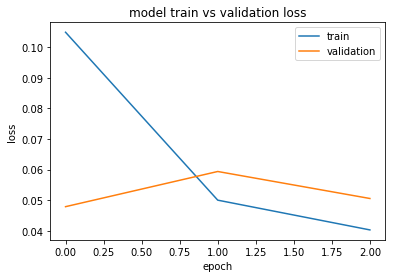

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267]
49 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1186 samples, validate on 300 samples
Epoch 1/3
1186/1186 [==============================] - 8s 7ms/step - loss: 0.1648 - val_loss: 0.1173
Epoch 2/3
1186/1186 [==============================] - 0s 91us/step - loss: 0.0645 - val_loss: 0.0495
Epoch 3/3
1186/1186 [==============================] - 0s 94us/step - loss: 0.0460 - val_loss: 0.0496


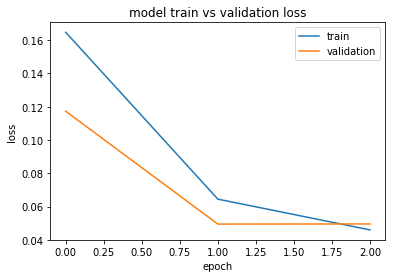

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189]
50 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1187 samples, validate on 300 samples
Epoch 1/3
1187/1187 [==============================] - 8s 7ms/step - loss: 0.0767 - val_loss: 0.0521
Epoch 2/3
1187/1187 [==============================] - 0s 99us/step - loss: 0.0454 - val_loss: 0.0502
Epoch 3/3
1187/1187 [==============================] - 0s 95us/step - loss: 0.0385 - val_loss: 0.0522


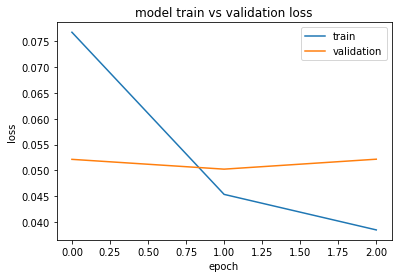

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414]
51 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1188 samples, validate on 300 samples
Epoch 1/3
1188/1188 [==============================] - 8s 7ms/step - loss: 0.2945 - val_loss: 0.1113
Epoch 2/3
1188/1188 [==============================] - 0s 93us/step - loss: 0.1175 - val_loss: 0.0585
Epoch 3/3
1188/1188 [==============================] - 0s 96us/step - loss: 0.0567 - val_loss: 0.0540


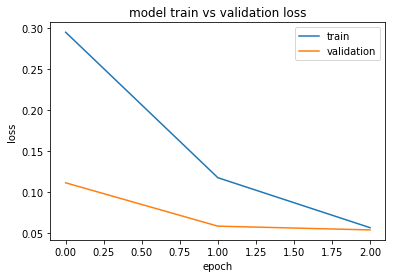

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654]
52 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1189 samples, validate on 300 samples
Epoch 1/3
1189/1189 [==============================] - 8s 7ms/step - loss: 0.0799 - val_loss: 0.0687
Epoch 2/3
1189/1189 [==============================] - 0s 100us/step - loss: 0.0528 - val_loss: 0.0499
Epoch 3/3
1189/1189 [==============================] - 0s 93us/step - loss: 0.0404 - val_loss: 0.0479


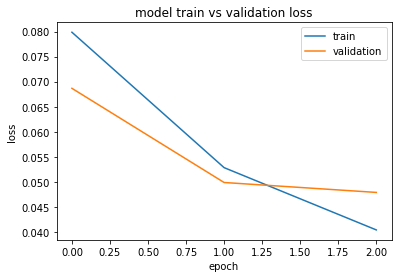

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039]
53 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1190 samples, validate on 300 samples
Epoch 1/3
1190/1190 [==============================] - 9s 7ms/step - loss: 0.1057 - val_loss: 0.0621
Epoch 2/3
1190/1190 [==============================] - 0s 89us/step - loss: 0.0468 - val_loss: 0.0519
Epoch 3/3
1190/1190 [==============================] - 0s 87us/step - loss: 0.0419 - val_loss: 0.0500


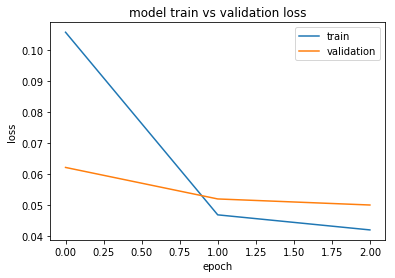

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006]
54 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1191 samples, validate on 300 samples
Epoch 1/3
1191/1191 [==============================] - 9s 7ms/step - loss: 0.0581 - val_loss: 0.0530
Epoch 2/3
1191/1191 [==============================] - 0s 103us/step - loss: 0.0496 - val_loss: 0.0483
Epoch 3/3
1191/1191 [==============================] - 0s 98us/step - loss: 0.0447 - val_loss: 0.0596


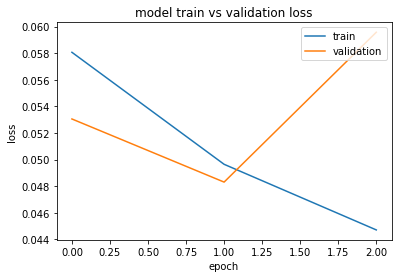

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749]
55 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1192 samples, validate on 300 samples
Epoch 1/3
1192/1192 [==============================] - 10s 8ms/step - loss: 0.5016 - val_loss: 0.1615
Epoch 2/3
1192/1192 [==============================] - 0s 100us/step - loss: 0.1010 - val_loss: 0.0938
Epoch 3/3
1192/1192 [==============================] - 0s 103us/step - loss: 0.0586 - val_loss: 0.0663


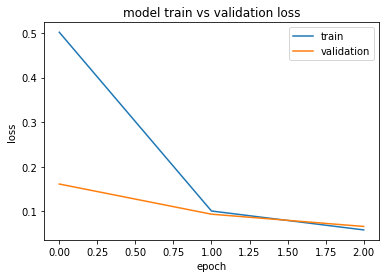

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755]
56 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1193 samples, validate on 300 samples
Epoch 1/3
1193/1193 [==============================] - 9s 8ms/step - loss: 0.6473 - val_loss: 0.1924
Epoch 2/3
1193/1193 [==============================] - 0s 94us/step - loss: 0.1250 - val_loss: 0.1321
Epoch 3/3
1193/1193 [==============================] - 0s 99us/step - loss: 0.0734 - val_loss: 0.0788


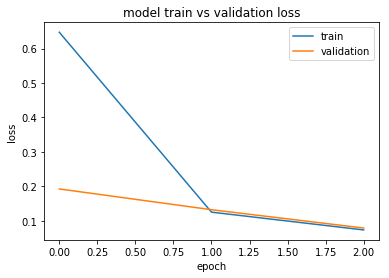

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954]
57 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1194 samples, validate on 300 samples
Epoch 1/3
1194/1194 [==============================] - 10s 8ms/step - loss: 0.0604 - val_loss: 0.0539
Epoch 2/3
1194/1194 [==============================] - 0s 95us/step - loss: 0.0395 - val_loss: 0.0475
Epoch 3/3
1194/1194 [==============================] - 0s 93us/step - loss: 0.0386 - val_loss: 0.0490


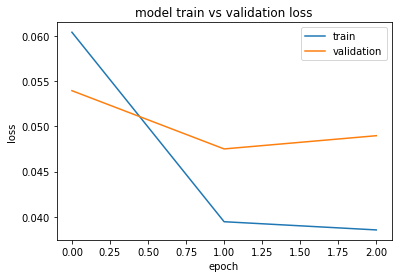

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793]
58 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1195 samples, validate on 300 samples
Epoch 1/3
1195/1195 [==============================] - 10s 8ms/step - loss: 0.1750 - val_loss: 0.1194
Epoch 2/3
1195/1195 [==============================] - 0s 95us/step - loss: 0.0682 - val_loss: 0.0510
Epoch 3/3
1195/1195 [==============================] - 0s 98us/step - loss: 0.0458 - val_loss: 0.0541


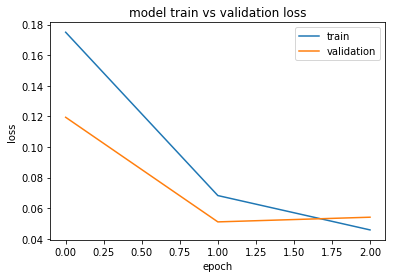

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259]
59 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1196 samples, validate on 300 samples
Epoch 1/3
1196/1196 [==============================] - 10s 8ms/step - loss: 0.0591 - val_loss: 0.0598
Epoch 2/3
1196/1196 [==============================] - 0s 99us/step - loss: 0.0447 - val_loss: 0.0500
Epoch 3/3
1196/1196 [==============================] - 0s 109us/step - loss: 0.0381 - val_loss: 0.0479


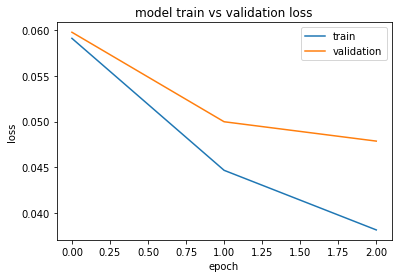

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892]
60 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1197 samples, validate on 300 samples
Epoch 1/3
1197/1197 [==============================] - 10s 8ms/step - loss: 0.3322 - val_loss: 0.0990
Epoch 2/3
1197/1197 [==============================] - 0s 96us/step - loss: 0.1083 - val_loss: 0.0515
Epoch 3/3
1197/1197 [==============================] - 0s 96us/step - loss: 0.0575 - val_loss: 0.0565


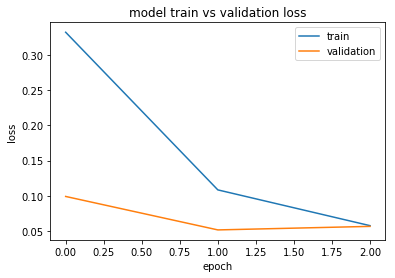

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672]
61 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1198 samples, validate on 300 samples
Epoch 1/3
1198/1198 [==============================] - 10s 9ms/step - loss: 0.2431 - val_loss: 0.1451
Epoch 2/3
1198/1198 [==============================] - 0s 105us/step - loss: 0.0902 - val_loss: 0.0864
Epoch 3/3
1198/1198 [==============================] - 0s 95us/step - loss: 0.0575 - val_loss: 0.0592


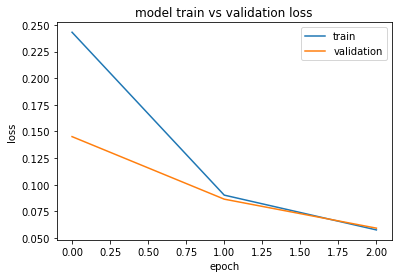

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512]
62 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1199 samples, validate on 300 samples
Epoch 1/3
1199/1199 [==============================] - 10s 9ms/step - loss: 0.1308 - val_loss: 0.0695
Epoch 2/3
1199/1199 [==============================] - 0s 100us/step - loss: 0.0551 - val_loss: 0.0608
Epoch 3/3
1199/1199 [==============================] - 0s 103us/step - loss: 0.0478 - val_loss: 0.0563


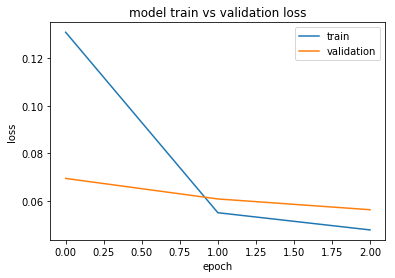

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155]
63 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1200 samples, validate on 300 samples
Epoch 1/3
1200/1200 [==============================] - 11s 9ms/step - loss: 0.3669 - val_loss: 0.0623
Epoch 2/3
1200/1200 [==============================] - 0s 87us/step - loss: 0.1178 - val_loss: 0.0527
Epoch 3/3
1200/1200 [==============================] - 0s 90us/step - loss: 0.0608 - val_loss: 0.0510


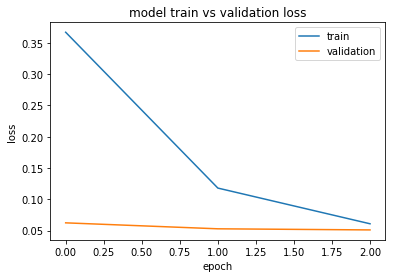

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684]
64 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1201 samples, validate on 300 samples
Epoch 1/3
1201/1201 [==============================] - 11s 9ms/step - loss: 0.0508 - val_loss: 0.0498
Epoch 2/3
1201/1201 [==============================] - 0s 99us/step - loss: 0.0367 - val_loss: 0.0523
Epoch 3/3
1201/1201 [==============================] - 0s 97us/step - loss: 0.0396 - val_loss: 0.0492


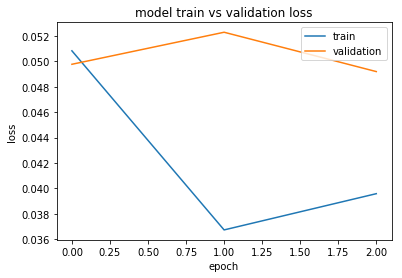

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994]
65 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1202 samples, validate on 300 samples
Epoch 1/3
1202/1202 [==============================] - 11s 9ms/step - loss: 0.1050 - val_loss: 0.0506
Epoch 2/3
1202/1202 [==============================] - 0s 100us/step - loss: 0.0520 - val_loss: 0.0560
Epoch 3/3
1202/1202 [==============================] - 0s 95us/step - loss: 0.0414 - val_loss: 0.0495


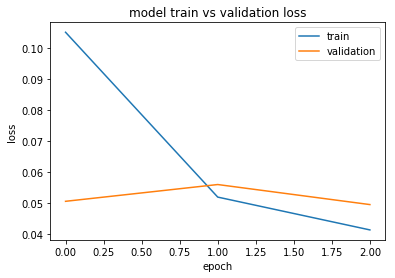

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962]
66 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1203 samples, validate on 300 samples
Epoch 1/3
1203/1203 [==============================] - 11s 9ms/step - loss: 0.3232 - val_loss: 0.1419
Epoch 2/3
1203/1203 [==============================] - 0s 102us/step - loss: 0.1036 - val_loss: 0.0844
Epoch 3/3
1203/1203 [==============================] - 0s 102us/step - loss: 0.0606 - val_loss: 0.0625


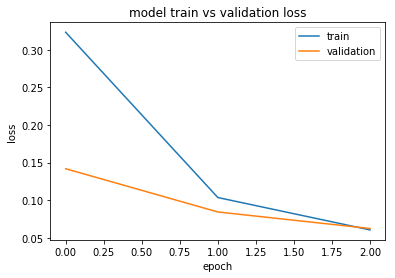

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053]
67 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1204 samples, validate on 300 samples
Epoch 1/3
1204/1204 [==============================] - 11s 9ms/step - loss: 0.0751 - val_loss: 0.0664
Epoch 2/3
1204/1204 [==============================] - 0s 110us/step - loss: 0.0459 - val_loss: 0.0575
Epoch 3/3
1204/1204 [==============================] - 0s 118us/step - loss: 0.0393 - val_loss: 0.0503


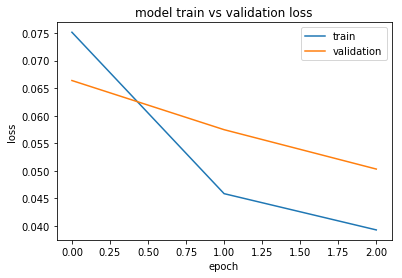

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573]
68 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1205 samples, validate on 300 samples
Epoch 1/3
1205/1205 [==============================] - 11s 9ms/step - loss: 0.3572 - val_loss: 0.0887
Epoch 2/3
1205/1205 [==============================] - 0s 92us/step - loss: 0.1036 - val_loss: 0.0654
Epoch 3/3
1205/1205 [==============================] - 0s 91us/step - loss: 0.0532 - val_loss: 0.0584


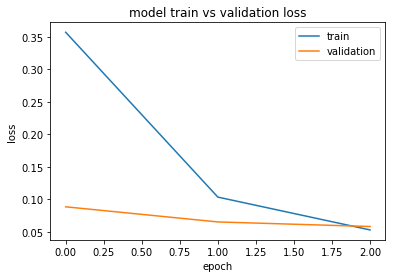

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977]
69 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1206 samples, validate on 300 samples
Epoch 1/3
1206/1206 [==============================] - 13s 10ms/step - loss: 0.0532 - val_loss: 0.0526
Epoch 2/3
1206/1206 [==============================] - 0s 98us/step - loss: 0.0408 - val_loss: 0.0520
Epoch 3/3
1206/1206 [==============================] - 0s 104us/step - loss: 0.0378 - val_loss: 0.0488


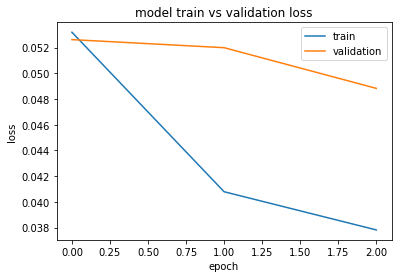

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366]
70 129


/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1207 samples, validate on 300 samples
Epoch 1/3
1207/1207 [==============================] - 12s 10ms/step - loss: 0.2261 - val_loss: 0.1415
Epoch 2/3
1207/1207 [==============================] - 0s 102us/step - loss: 0.0822 - val_loss: 0.0819
Epoch 3/3
1207/1207 [==============================] - 0s 102us/step - loss: 0.0533 - val_loss: 0.0539


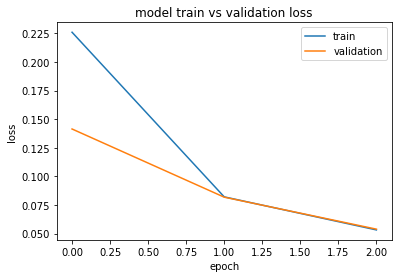

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997]
71 129

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1208 samples, validate on 300 samples
Epoch 1/3
1208/1208 [==============================] - 13s 11ms/step - loss: 0.2003 - val_loss: 0.1341
Epoch 2/3
1208/1208 [==============================] - 0s 100us/step - loss: 0.0793 - val_loss: 0.0816
Epoch 3/3
1208/1208 [==============================] - 0s 101us/step - loss: 0.0526 - val_loss: 0.0607


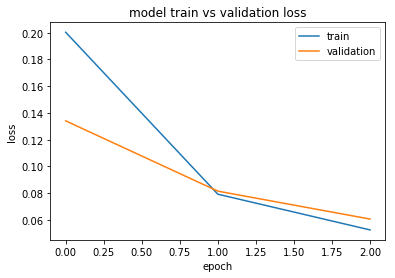

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1209 samples, validate on 300 samples
Epoch 1/3
1209/1209 [==============================] - 13s 11ms/step - loss: 0.6087 - val_loss: 0.3000
Epoch 2/3
1209/1209 [==============================] - 0s 97us/step - loss: 0.1430 - val_loss: 0.1110
Epoch 3/3
1209/1209 [==============================] - 0s 102us/step - loss: 0.0834 - val_loss: 0.0532


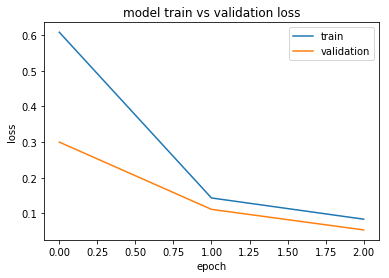

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1210 samples, validate on 300 samples
Epoch 1/3
1210/1210 [==============================] - 13s 11ms/step - loss: 0.0987 - val_loss: 0.0529
Epoch 2/3
1210/1210 [==============================] - 0s 88us/step - loss: 0.0493 - val_loss: 0.0549
Epoch 3/3
1210/1210 [==============================] - 0s 87us/step - loss: 0.0422 - val_loss: 0.0536


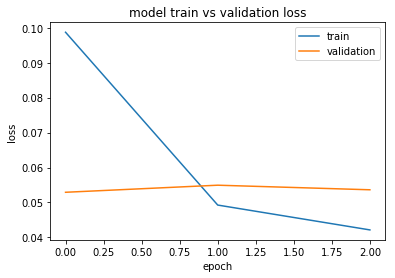

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1211 samples, validate on 300 samples
Epoch 1/3
1211/1211 [==============================] - 13s 11ms/step - loss: 0.0450 - val_loss: 0.0536
Epoch 2/3
1211/1211 [==============================] - 0s 106us/step - loss: 0.0395 - val_loss: 0.0513
Epoch 3/3
1211/1211 [==============================] - 0s 97us/step - loss: 0.0391 - val_loss: 0.0580


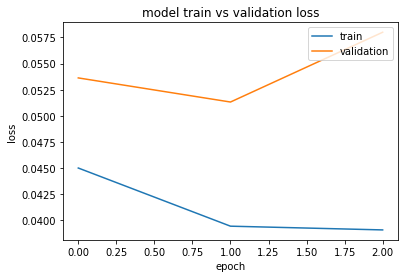

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1212 samples, validate on 300 samples
Epoch 1/3
1212/1212 [==============================] - 13s 11ms/step - loss: 0.0489 - val_loss: 0.0633
Epoch 2/3
1212/1212 [==============================] - 0s 100us/step - loss: 0.0478 - val_loss: 0.0519
Epoch 3/3
1212/1212 [==============================] - 0s 103us/step - loss: 0.0431 - val_loss: 0.0501


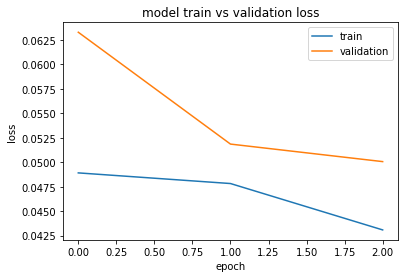

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1213 samples, validate on 300 samples
Epoch 1/3
1213/1213 [==============================] - 13s 11ms/step - loss: 0.9421 - val_loss: 0.4896
Epoch 2/3
1213/1213 [==============================] - 0s 96us/step - loss: 0.2307 - val_loss: 0.1574
Epoch 3/3
1213/1213 [==============================] - 0s 103us/step - loss: 0.1316 - val_loss: 0.0682


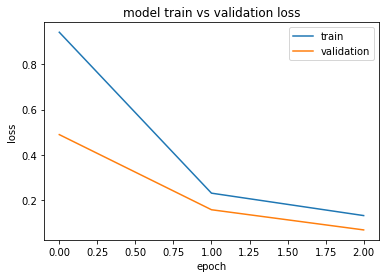

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1214 samples, validate on 300 samples
Epoch 1/3
1214/1214 [==============================] - 14s 11ms/step - loss: 0.2221 - val_loss: 0.1443
Epoch 2/3
1214/1214 [==============================] - 0s 111us/step - loss: 0.0804 - val_loss: 0.0684
Epoch 3/3
1214/1214 [==============================] - 0s 99us/step - loss: 0.0521 - val_loss: 0.0485


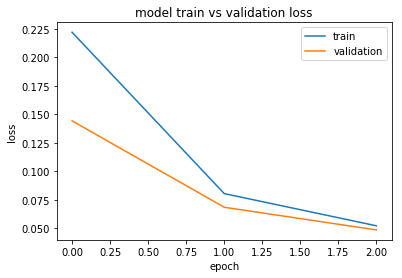

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1215 samples, validate on 300 samples
Epoch 1/3
1215/1215 [==============================] - 14s 11ms/step - loss: 0.1552 - val_loss: 0.1026
Epoch 2/3
1215/1215 [==============================] - 0s 90us/step - loss: 0.0637 - val_loss: 0.0504
Epoch 3/3
1215/1215 [==============================] - 0s 96us/step - loss: 0.0431 - val_loss: 0.0512


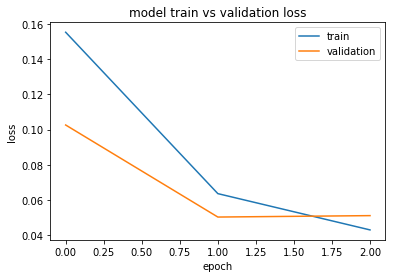

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1216 samples, validate on 300 samples
Epoch 1/3
1216/1216 [==============================] - 14s 12ms/step - loss: 0.1046 - val_loss: 0.0475
Epoch 2/3
1216/1216 [==============================] - 0s 108us/step - loss: 0.0418 - val_loss: 0.0497
Epoch 3/3
1216/1216 [==============================] - 0s 102us/step - loss: 0.0364 - val_loss: 0.0464


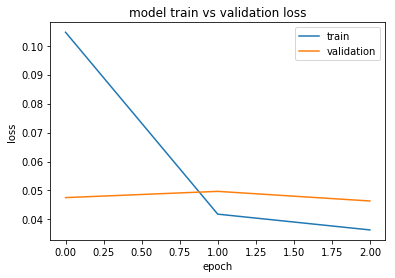

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1217 samples, validate on 300 samples
Epoch 1/3
1217/1217 [==============================] - 14s 12ms/step - loss: 0.1524 - val_loss: 0.0947
Epoch 2/3
1217/1217 [==============================] - 0s 101us/step - loss: 0.0587 - val_loss: 0.0536
Epoch 3/3
1217/1217 [==============================] - 0s 102us/step - loss: 0.0425 - val_loss: 0.0520


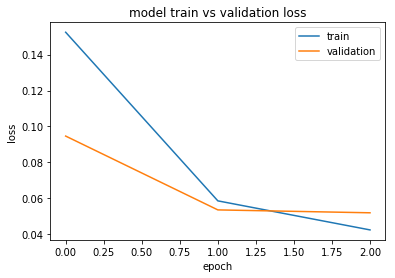

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1218 samples, validate on 300 samples
Epoch 1/3
1218/1218 [==============================] - 15s 12ms/step - loss: 0.1446 - val_loss: 0.0701
Epoch 2/3
1218/1218 [==============================] - 0s 94us/step - loss: 0.0564 - val_loss: 0.0500
Epoch 3/3
1218/1218 [==============================] - 0s 92us/step - loss: 0.0416 - val_loss: 0.0542


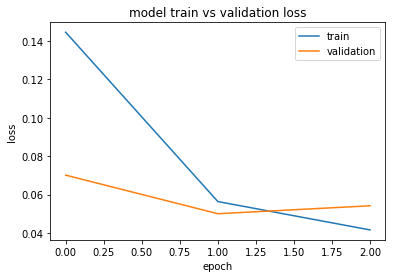

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1219 samples, validate on 300 samples
Epoch 1/3
1219/1219 [==============================] - 15s 12ms/step - loss: 0.2577 - val_loss: 0.1076
Epoch 2/3
1219/1219 [==============================] - 0s 96us/step - loss: 0.0862 - val_loss: 0.0612
Epoch 3/3
1219/1219 [==============================] - 0s 100us/step - loss: 0.0504 - val_loss: 0.0566


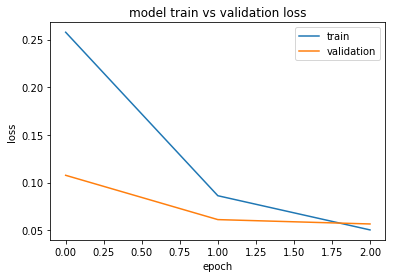

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1220 samples, validate on 300 samples
Epoch 1/3
1220/1220 [==============================] - 15s 12ms/step - loss: 0.5236 - val_loss: 0.2326
Epoch 2/3
1220/1220 [==============================] - 0s 103us/step - loss: 0.1161 - val_loss: 0.1308
Epoch 3/3
1220/1220 [==============================] - 0s 96us/step - loss: 0.0753 - val_loss: 0.0768


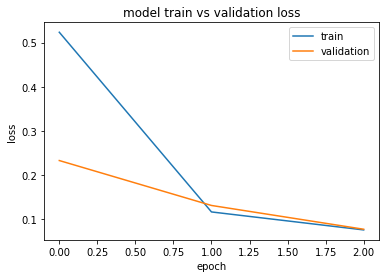

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1221 samples, validate on 300 samples
Epoch 1/3
1221/1221 [==============================] - 15s 12ms/step - loss: 0.6641 - val_loss: 0.2045
Epoch 2/3
1221/1221 [==============================] - 0s 102us/step - loss: 0.1260 - val_loss: 0.1325
Epoch 3/3
1221/1221 [==============================] - 0s 103us/step - loss: 0.0767 - val_loss: 0.0812


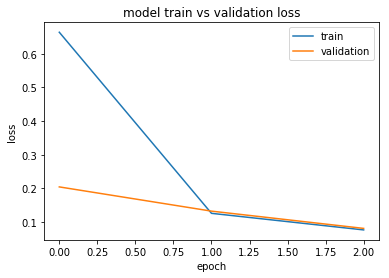

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1222 samples, validate on 300 samples
Epoch 1/3
1222/1222 [==============================] - 15s 13ms/step - loss: 0.0455 - val_loss: 0.0545
Epoch 2/3
1222/1222 [==============================] - 0s 106us/step - loss: 0.0398 - val_loss: 0.0463
Epoch 3/3
1222/1222 [==============================] - 0s 105us/step - loss: 0.0401 - val_loss: 0.0470


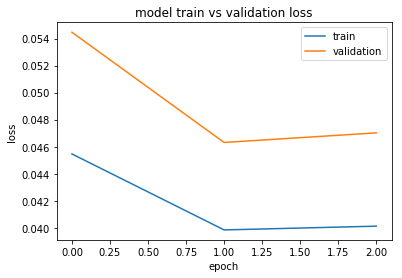

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1223 samples, validate on 300 samples
Epoch 1/3
1223/1223 [==============================] - 17s 14ms/step - loss: 0.0706 - val_loss: 0.0650
Epoch 2/3
1223/1223 [==============================] - 0s 108us/step - loss: 0.0413 - val_loss: 0.0535
Epoch 3/3
1223/1223 [==============================] - 0s 101us/step - loss: 0.0420 - val_loss: 0.0471


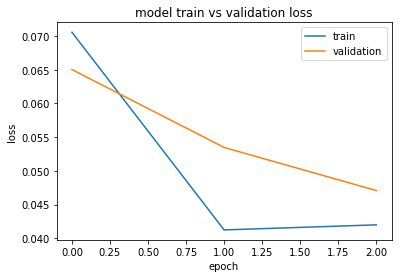

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1224 samples, validate on 300 samples
Epoch 1/3
1224/1224 [==============================] - 17s 14ms/step - loss: 1.0449 - val_loss: 0.7054
Epoch 2/3
1224/1224 [==============================] - 0s 104us/step - loss: 0.4960 - val_loss: 0.2165
Epoch 3/3
1224/1224 [==============================] - 0s 102us/step - loss: 0.1032 - val_loss: 0.1215


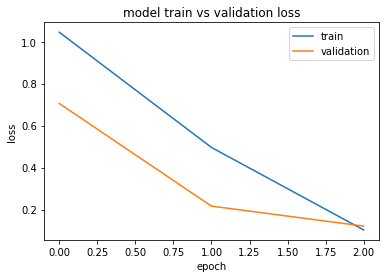

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1225 samples, validate on 300 samples
Epoch 1/3
1225/1225 [==============================] - 17s 14ms/step - loss: 0.2022 - val_loss: 0.1288
Epoch 2/3
1225/1225 [==============================] - 0s 100us/step - loss: 0.0740 - val_loss: 0.0756
Epoch 3/3
1225/1225 [==============================] - 0s 107us/step - loss: 0.0499 - val_loss: 0.0489


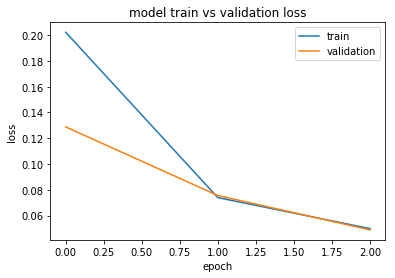

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1226 samples, validate on 300 samples
Epoch 1/3
1226/1226 [==============================] - 17s 14ms/step - loss: 0.4807 - val_loss: 0.0821
Epoch 2/3
1226/1226 [==============================] - 0s 102us/step - loss: 0.1123 - val_loss: 0.0818
Epoch 3/3
1226/1226 [==============================] - 0s 100us/step - loss: 0.0636 - val_loss: 0.0600


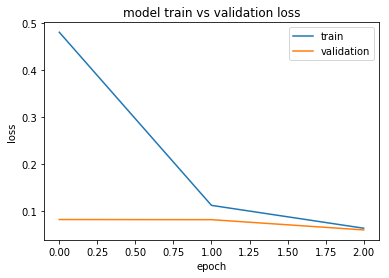

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1227 samples, validate on 300 samples
Epoch 1/3
1227/1227 [==============================] - 17s 14ms/step - loss: 0.0495 - val_loss: 0.0506
Epoch 2/3
1227/1227 [==============================] - 0s 105us/step - loss: 0.0377 - val_loss: 0.0487
Epoch 3/3
1227/1227 [==============================] - 0s 112us/step - loss: 0.0358 - val_loss: 0.0475


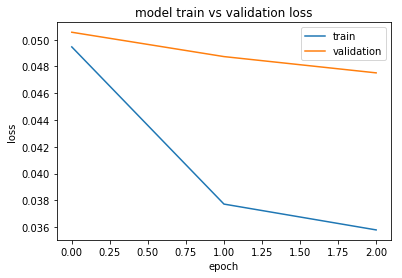

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1228 samples, validate on 300 samples
Epoch 1/3
1228/1228 [==============================] - 17s 14ms/step - loss: 0.0455 - val_loss: 0.0497
Epoch 2/3
1228/1228 [==============================] - 0s 105us/step - loss: 0.0355 - val_loss: 0.0495
Epoch 3/3
1228/1228 [==============================] - 0s 104us/step - loss: 0.0353 - val_loss: 0.0491


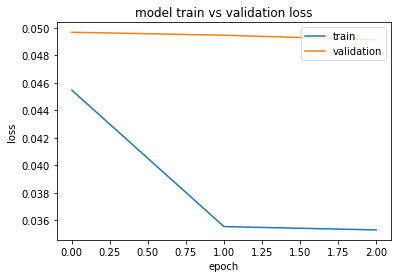

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1229 samples, validate on 300 samples
Epoch 1/3
1229/1229 [==============================] - 17s 14ms/step - loss: 0.2526 - val_loss: 0.1237
Epoch 2/3
1229/1229 [==============================] - 0s 101us/step - loss: 0.0840 - val_loss: 0.0810
Epoch 3/3
1229/1229 [==============================] - 0s 105us/step - loss: 0.0502 - val_loss: 0.0495


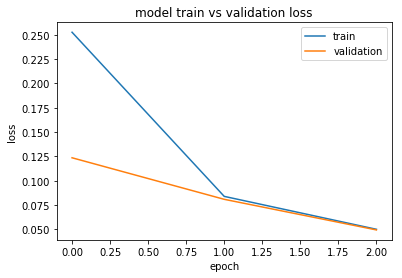

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1230 samples, validate on 300 samples
Epoch 1/3
1230/1230 [==============================] - 18s 14ms/step - loss: 0.1116 - val_loss: 0.0653
Epoch 2/3
1230/1230 [==============================] - 0s 91us/step - loss: 0.0561 - val_loss: 0.0551
Epoch 3/3
1230/1230 [==============================] - 0s 95us/step - loss: 0.0452 - val_loss: 0.0569


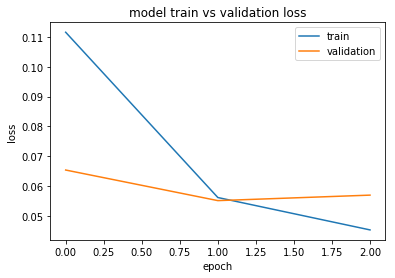

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1231 samples, validate on 300 samples
Epoch 1/3
1231/1231 [==============================] - 18s 15ms/step - loss: 0.3095 - val_loss: 0.1070
Epoch 2/3
1231/1231 [==============================] - 0s 92us/step - loss: 0.0920 - val_loss: 0.0699
Epoch 3/3
1231/1231 [==============================] - 0s 101us/step - loss: 0.0532 - val_loss: 0.0566


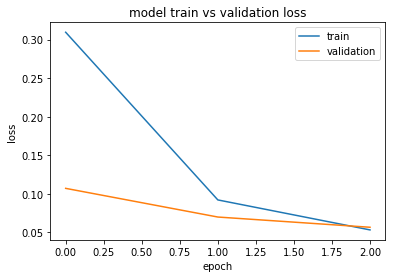

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1232 samples, validate on 300 samples
Epoch 1/3
1232/1232 [==============================] - 18s 15ms/step - loss: 0.2091 - val_loss: 0.1446
Epoch 2/3
1232/1232 [==============================] - 0s 100us/step - loss: 0.0798 - val_loss: 0.0701
Epoch 3/3
1232/1232 [==============================] - 0s 94us/step - loss: 0.0480 - val_loss: 0.0547


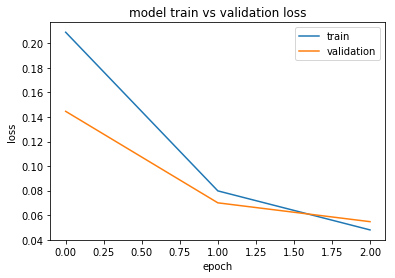

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1233 samples, validate on 300 samples
Epoch 1/3
1233/1233 [==============================] - 18s 15ms/step - loss: 0.1323 - val_loss: 0.0595
Epoch 2/3
1233/1233 [==============================] - 0s 107us/step - loss: 0.0536 - val_loss: 0.0597
Epoch 3/3
1233/1233 [==============================] - 0s 101us/step - loss: 0.0473 - val_loss: 0.0511


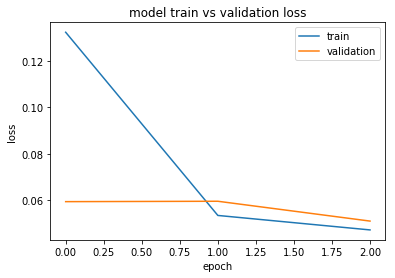

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1234 samples, validate on 300 samples
Epoch 1/3
1234/1234 [==============================] - 19s 15ms/step - loss: 0.5750 - val_loss: 0.0875
Epoch 2/3
1234/1234 [==============================] - 0s 101us/step - loss: 0.1293 - val_loss: 0.0828
Epoch 3/3
1234/1234 [==============================] - 0s 113us/step - loss: 0.0677 - val_loss: 0.0546


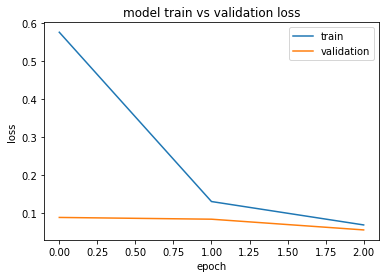

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1235 samples, validate on 300 samples
Epoch 1/3
1235/1235 [==============================] - 19s 15ms/step - loss: 0.5554 - val_loss: 0.1300
Epoch 2/3
1235/1235 [==============================] - 0s 102us/step - loss: 0.1141 - val_loss: 0.0940
Epoch 3/3
1235/1235 [==============================] - 0s 106us/step - loss: 0.0643 - val_loss: 0.0644


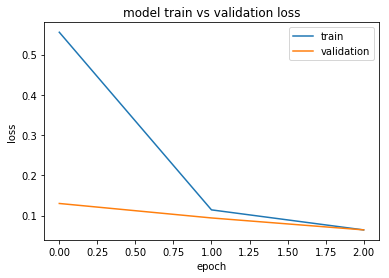

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1236 samples, validate on 300 samples
Epoch 1/3
1236/1236 [==============================] - 19s 16ms/step - loss: 0.0602 - val_loss: 0.0482
Epoch 2/3
1236/1236 [==============================] - 0s 113us/step - loss: 0.0396 - val_loss: 0.0469
Epoch 3/3
1236/1236 [==============================] - 0s 108us/step - loss: 0.0351 - val_loss: 0.0469


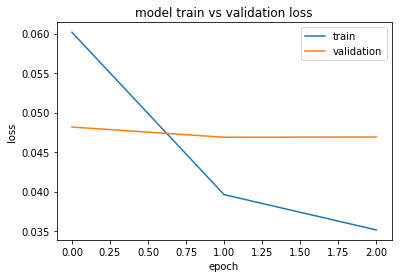

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1237 samples, validate on 300 samples
Epoch 1/3
1237/1237 [==============================] - 19s 16ms/step - loss: 0.1146 - val_loss: 0.0499
Epoch 2/3
1237/1237 [==============================] - 0s 96us/step - loss: 0.0464 - val_loss: 0.0519
Epoch 3/3
1237/1237 [==============================] - 0s 102us/step - loss: 0.0389 - val_loss: 0.0469


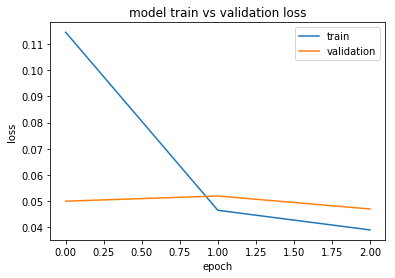

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1238 samples, validate on 300 samples
Epoch 1/3
1238/1238 [==============================] - 20s 16ms/step - loss: 0.2349 - val_loss: 0.1352
Epoch 2/3
1238/1238 [==============================] - 0s 99us/step - loss: 0.0799 - val_loss: 0.0741
Epoch 3/3
1238/1238 [==============================] - 0s 96us/step - loss: 0.0477 - val_loss: 0.0484


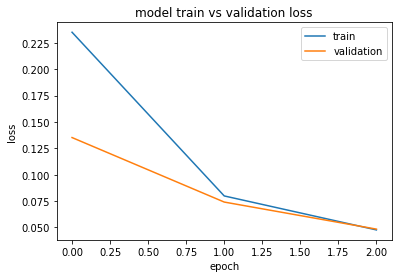

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1239 samples, validate on 300 samples
Epoch 1/3
1239/1239 [==============================] - 20s 16ms/step - loss: 0.0679 - val_loss: 0.0588
Epoch 2/3
1239/1239 [==============================] - 0s 103us/step - loss: 0.0428 - val_loss: 0.0503
Epoch 3/3
1239/1239 [==============================] - 0s 104us/step - loss: 0.0370 - val_loss: 0.0473


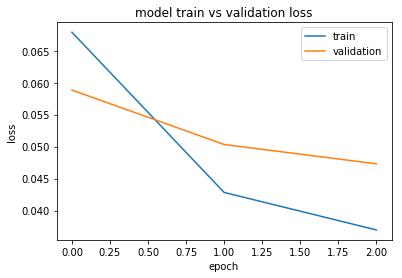

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1240 samples, validate on 300 samples
Epoch 1/3
1240/1240 [==============================] - 20s 16ms/step - loss: 0.1501 - val_loss: 0.1013
Epoch 2/3
1240/1240 [==============================] - 0s 112us/step - loss: 0.0619 - val_loss: 0.0594
Epoch 3/3
1240/1240 [==============================] - 0s 92us/step - loss: 0.0415 - val_loss: 0.0487


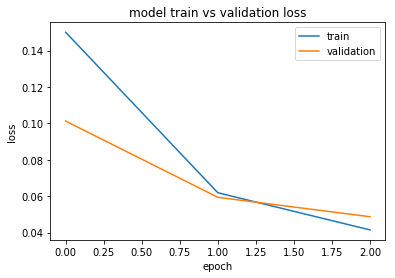

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1241 samples, validate on 300 samples
Epoch 1/3
1241/1241 [==============================] - 20s 16ms/step - loss: 0.0500 - val_loss: 0.0511
Epoch 2/3
1241/1241 [==============================] - 0s 111us/step - loss: 0.0417 - val_loss: 0.0522
Epoch 3/3
1241/1241 [==============================] - 0s 109us/step - loss: 0.0390 - val_loss: 0.0493


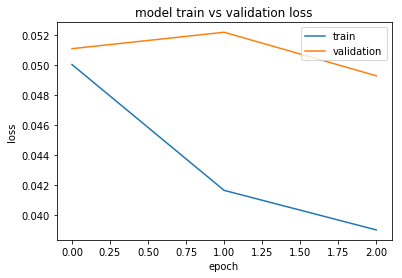

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1242 samples, validate on 300 samples
Epoch 1/3
1242/1242 [==============================] - 20s 16ms/step - loss: 0.6350 - val_loss: 0.2353
Epoch 2/3
1242/1242 [==============================] - 0s 103us/step - loss: 0.1253 - val_loss: 0.1272
Epoch 3/3
1242/1242 [==============================] - 0s 94us/step - loss: 0.0715 - val_loss: 0.0774


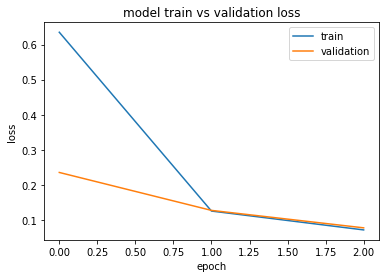

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1243 samples, validate on 300 samples
Epoch 1/3
1243/1243 [==============================] - 21s 17ms/step - loss: 0.2152 - val_loss: 0.1353
Epoch 2/3
1243/1243 [==============================] - 0s 104us/step - loss: 0.0825 - val_loss: 0.0707
Epoch 3/3
1243/1243 [==============================] - 0s 102us/step - loss: 0.0472 - val_loss: 0.0519


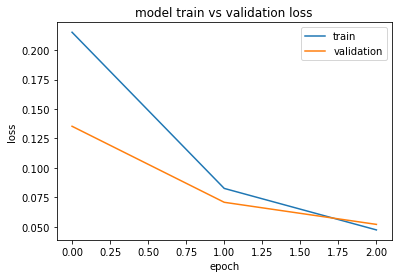

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1244 samples, validate on 300 samples
Epoch 1/3
1244/1244 [==============================] - 23s 18ms/step - loss: 0.1444 - val_loss: 0.0830
Epoch 2/3
1244/1244 [==============================] - 0s 96us/step - loss: 0.0544 - val_loss: 0.0483
Epoch 3/3
1244/1244 [==============================] - 0s 101us/step - loss: 0.0409 - val_loss: 0.0517


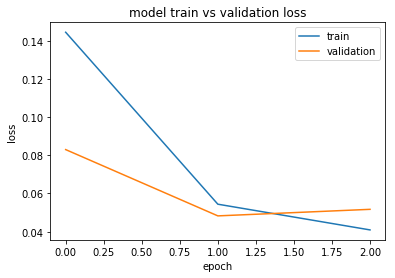

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1245 samples, validate on 300 samples
Epoch 1/3
1245/1245 [==============================] - 22s 18ms/step - loss: 0.1429 - val_loss: 0.1013
Epoch 2/3
1245/1245 [==============================] - 0s 110us/step - loss: 0.0622 - val_loss: 0.0533
Epoch 3/3
1245/1245 [==============================] - 0s 113us/step - loss: 0.0430 - val_loss: 0.0491


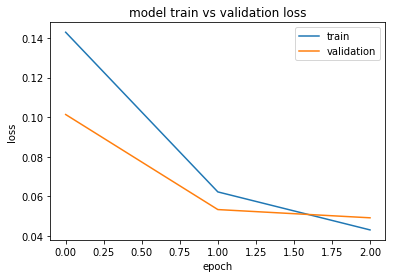

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1246 samples, validate on 300 samples
Epoch 1/3
1246/1246 [==============================] - 23s 18ms/step - loss: 0.2274 - val_loss: 0.1301
Epoch 2/3
1246/1246 [==============================] - 0s 103us/step - loss: 0.0798 - val_loss: 0.0720
Epoch 3/3
1246/1246 [==============================] - 0s 100us/step - loss: 0.0455 - val_loss: 0.0523


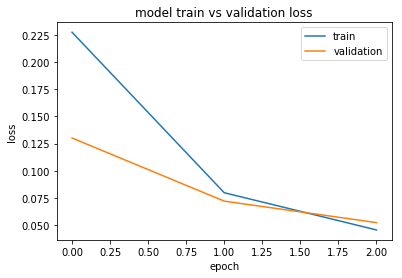

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1247 samples, validate on 300 samples
Epoch 1/3
1247/1247 [==============================] - 23s 18ms/step - loss: 0.7088 - val_loss: 0.3093
Epoch 2/3
1247/1247 [==============================] - 0s 107us/step - loss: 0.1434 - val_loss: 0.1474
Epoch 3/3
1247/1247 [==============================] - 0s 114us/step - loss: 0.0855 - val_loss: 0.0802


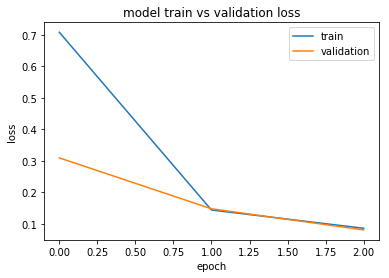

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1248 samples, validate on 300 samples
Epoch 1/3
1248/1248 [==============================] - 23s 18ms/step - loss: 0.2463 - val_loss: 0.1350
Epoch 2/3
1248/1248 [==============================] - 0s 110us/step - loss: 0.0957 - val_loss: 0.0788
Epoch 3/3
1248/1248 [==============================] - 0s 107us/step - loss: 0.0530 - val_loss: 0.0558


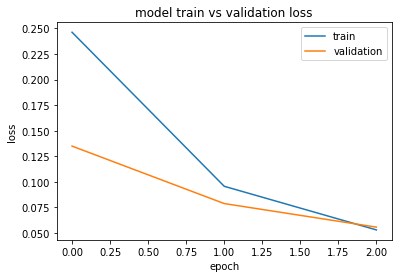

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1249 samples, validate on 300 samples
Epoch 1/3
1249/1249 [==============================] - 23s 18ms/step - loss: 0.0991 - val_loss: 0.0469
Epoch 2/3
1249/1249 [==============================] - 0s 105us/step - loss: 0.0463 - val_loss: 0.0543
Epoch 3/3
1249/1249 [==============================] - 0s 107us/step - loss: 0.0403 - val_loss: 0.0461


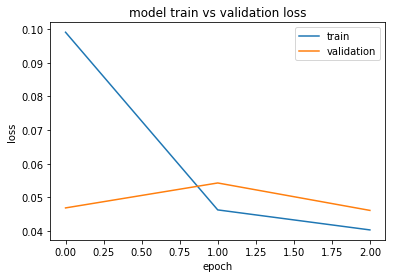

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1250 samples, validate on 300 samples
Epoch 1/3
1250/1250 [==============================] - 23s 19ms/step - loss: 0.1848 - val_loss: 0.1322
Epoch 2/3
1250/1250 [==============================] - 0s 93us/step - loss: 0.0794 - val_loss: 0.0822
Epoch 3/3
1250/1250 [==============================] - 0s 96us/step - loss: 0.0522 - val_loss: 0.0490


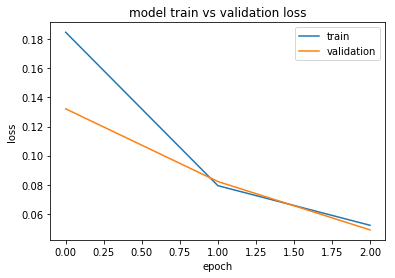

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1251 samples, validate on 300 samples
Epoch 1/3
1251/1251 [==============================] - 23s 19ms/step - loss: 0.4880 - val_loss: 0.0579
Epoch 2/3
1251/1251 [==============================] - 0s 112us/step - loss: 0.1378 - val_loss: 0.0513
Epoch 3/3
1251/1251 [==============================] - 0s 104us/step - loss: 0.0686 - val_loss: 0.0499


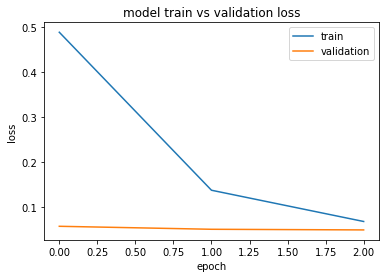

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1252 samples, validate on 300 samples
Epoch 1/3
1252/1252 [==============================] - 24s 19ms/step - loss: 0.1059 - val_loss: 0.0531
Epoch 2/3
1252/1252 [==============================] - 0s 101us/step - loss: 0.0466 - val_loss: 0.0534
Epoch 3/3
1252/1252 [==============================] - 0s 143us/step - loss: 0.0379 - val_loss: 0.0455


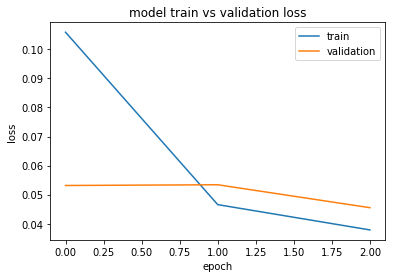

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1253 samples, validate on 300 samples
Epoch 1/3
1253/1253 [==============================] - 24s 19ms/step - loss: 0.0768 - val_loss: 0.0740
Epoch 2/3
1253/1253 [==============================] - 0s 111us/step - loss: 0.0471 - val_loss: 0.0471
Epoch 3/3
1253/1253 [==============================] - 0s 111us/step - loss: 0.0370 - val_loss: 0.0460


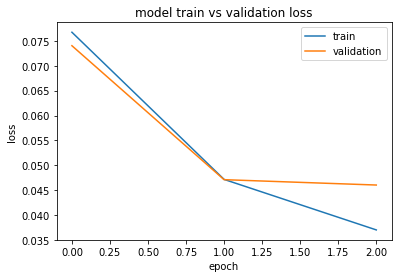

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1254 samples, validate on 300 samples
Epoch 1/3
1254/1254 [==============================] - 24s 19ms/step - loss: 0.2191 - val_loss: 0.1291
Epoch 2/3
1254/1254 [==============================] - 0s 103us/step - loss: 0.0788 - val_loss: 0.0748
Epoch 3/3
1254/1254 [==============================] - 0s 104us/step - loss: 0.0461 - val_loss: 0.0469


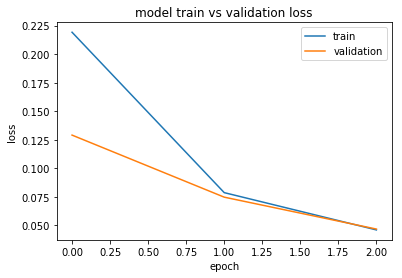

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1255 samples, validate on 300 samples
Epoch 1/3
1255/1255 [==============================] - 25s 20ms/step - loss: 0.2531 - val_loss: 0.1401
Epoch 2/3
1255/1255 [==============================] - 0s 155us/step - loss: 0.0946 - val_loss: 0.0796
Epoch 3/3
1255/1255 [==============================] - 0s 123us/step - loss: 0.0558 - val_loss: 0.0630


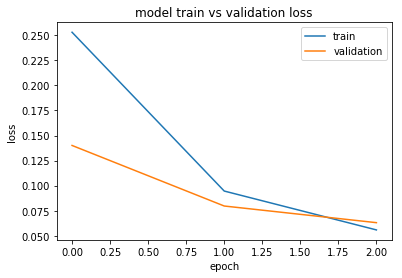

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1256 samples, validate on 300 samples
Epoch 1/3
1256/1256 [==============================] - 23s 19ms/step - loss: 0.0469 - val_loss: 0.0529
Epoch 2/3
1256/1256 [==============================] - 0s 68us/step - loss: 0.0389 - val_loss: 0.0461
Epoch 3/3
1256/1256 [==============================] - 0s 66us/step - loss: 0.0354 - val_loss: 0.0464


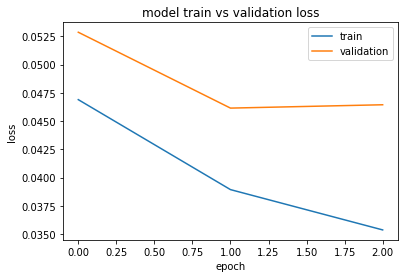

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1257 samples, validate on 300 samples
Epoch 1/3
1257/1257 [==============================] - 23s 19ms/step - loss: 0.0464 - val_loss: 0.0541
Epoch 2/3
1257/1257 [==============================] - 0s 68us/step - loss: 0.0405 - val_loss: 0.0482
Epoch 3/3
1257/1257 [==============================] - 0s 69us/step - loss: 0.0362 - val_loss: 0.0467


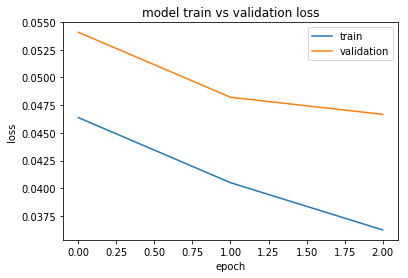

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1258 samples, validate on 300 samples
Epoch 1/3
1258/1258 [==============================] - 24s 19ms/step - loss: 0.0549 - val_loss: 0.0530
Epoch 2/3
1258/1258 [==============================] - 0s 71us/step - loss: 0.0411 - val_loss: 0.0494
Epoch 3/3
1258/1258 [==============================] - 0s 66us/step - loss: 0.0367 - val_loss: 0.0463


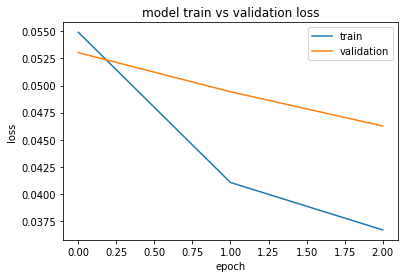

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1259 samples, validate on 300 samples
Epoch 1/3
1259/1259 [==============================] - 24s 19ms/step - loss: 0.1678 - val_loss: 0.1076
Epoch 2/3
1259/1259 [==============================] - 0s 67us/step - loss: 0.0652 - val_loss: 0.0639
Epoch 3/3
1259/1259 [==============================] - 0s 66us/step - loss: 0.0465 - val_loss: 0.0463


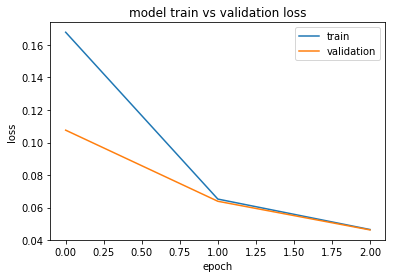

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1260 samples, validate on 300 samples
Epoch 1/3
1260/1260 [==============================] - 25s 20ms/step - loss: 0.1489 - val_loss: 0.0959
Epoch 2/3
1260/1260 [==============================] - 0s 63us/step - loss: 0.0651 - val_loss: 0.0533
Epoch 3/3
1260/1260 [==============================] - 0s 62us/step - loss: 0.0456 - val_loss: 0.0502


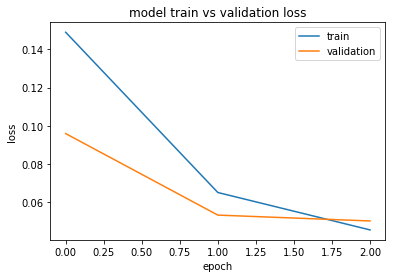

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1261 samples, validate on 300 samples
Epoch 1/3
1261/1261 [==============================] - 25s 20ms/step - loss: 0.0854 - val_loss: 0.0467
Epoch 2/3
1261/1261 [==============================] - 0s 72us/step - loss: 0.0386 - val_loss: 0.0472
Epoch 3/3
1261/1261 [==============================] - 0s 66us/step - loss: 0.0373 - val_loss: 0.0549


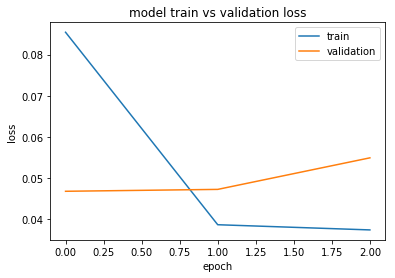

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1262 samples, validate on 300 samples
Epoch 1/3
1262/1262 [==============================] - 25s 20ms/step - loss: 0.0432 - val_loss: 0.0473
Epoch 2/3
1262/1262 [==============================] - 0s 69us/step - loss: 0.0363 - val_loss: 0.0544
Epoch 3/3
1262/1262 [==============================] - 0s 67us/step - loss: 0.0436 - val_loss: 0.0489


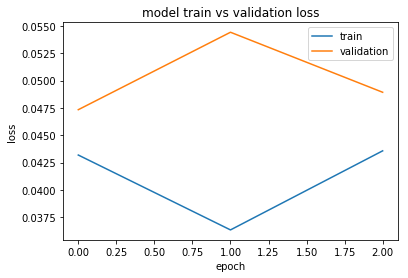

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1263 samples, validate on 300 samples
Epoch 1/3
1263/1263 [==============================] - 25s 20ms/step - loss: 0.2400 - val_loss: 0.1346
Epoch 2/3
1263/1263 [==============================] - 0s 68us/step - loss: 0.0866 - val_loss: 0.0766
Epoch 3/3
1263/1263 [==============================] - 0s 67us/step - loss: 0.0529 - val_loss: 0.0543


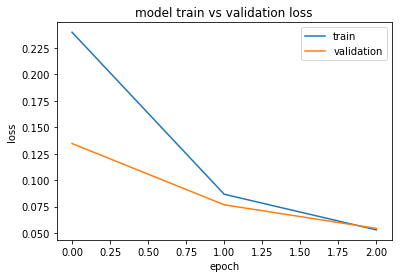

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 1264 samples, validate on 300 samples
Epoch 1/3
1264/1264 [==============================] - 26s 20ms/step - loss: 0.1752 - val_loss: 0.1214
Epoch 2/3
1264/1264 [==============================] - 0s 68us/step - loss: 0.0689 - val_loss: 0.0642
Epoch 3/3
1264/1264 [==============================] - 0s 68us/step - loss: 0.0458 - val_loss: 0.0499


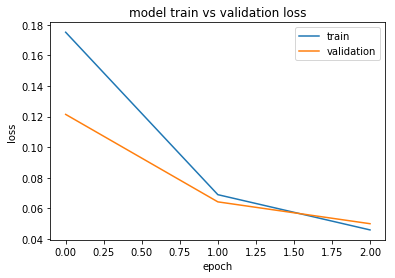

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

In [13]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import statsmodels.api as sm
from keras.callbacks import ReduceLROnPlateau

scalerX = MinMaxScaler(feature_range=(0, 1))
scalerY = MinMaxScaler(feature_range=(0, 1))
end = int(len(var1)/10)
test = val
for i in range(1, 2):
    variables_in = feature_importances.index[:15]
#     trainX = train1[variables_in]
#     trainY = train1['y_return_ratio']
    
#     valX = val[variables_in]
#     valY = val['y_return_ratio']
    predictions= []
    for i in range(len(test)):
        chunkX = pd.concat([train, test[:i]]).asfreq('B', method='bfill').fillna(method='bfill')[variables_in]
        chunkY = pd.concat([train, test[:i]]).asfreq('B', method='bfill').fillna(method='bfill')['y_return_ratio']
        
        trainX = chunkX[:-300]
        trainY = chunkY[:-300]
        
        valX = chunkX[-300:]
        valY = chunkY[-300:]

        testX = test[i:i+1][variables_in]
        testY = test[i:i+1]['y_return_ratio']

        features_set = scalerX.fit_transform(trainX)
        features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
        labels = scalerY.fit_transform(np.array(trainY).reshape(-1, 1))

        val_features_set = scalerX.transform(valX)
        val_features_set = np.reshape(val_features_set, (val_features_set.shape[0], val_features_set.shape[1], 1))
        val_labels = scalerY.transform(np.array(valY).reshape(-1, 1))
        
        test_features_set = scalerX.transform(testX)
        test_features_set = np.reshape(test_features_set, (test_features_set.shape[0], test_features_set.shape[1], 1))
        
        model = Sequential()

        model.add(LSTM(units=features_set.shape[1], activation='sigmoid', input_shape=(features_set.shape[1], 1)))
        model.add(Dense(units = 1, activation='linear'))

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
        opt = Adam(lr=0.005)

        model.compile(optimizer = opt, loss = 'mae')
        history = model.fit(features_set, labels, epochs = 3, batch_size = int(len(trainX)/10), validation_data=(val_features_set, val_labels), callbacks=[es], verbose=1)
        
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model train vs validation loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right')
        plt.show()
        
        predictions.append(scalerY.inverse_transform(model.predict(test_features_set).reshape(-1, 1))[0][0])
        print(predictions)
        print(i, len(test))
#     predictions = scalerY.inverse_transform(predictions)

#     plt.plot(predictions)

[-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.0106

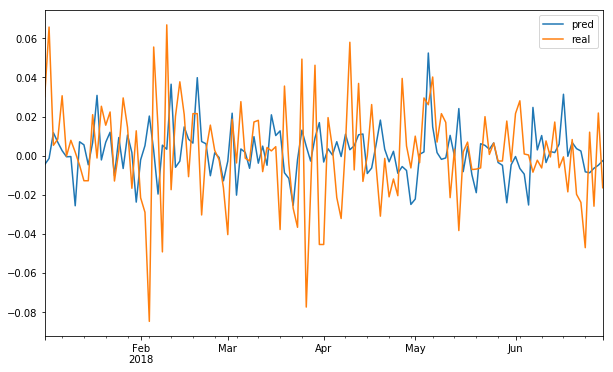

0.028504208213141063


In [14]:
print(predictions)
plt.figure(figsize=(10,6))
pd.Series(predictions, index=test.index[:len(predictions)]).plot(label='pred')
test['y_return_ratio'].plot(label="real")
plt.legend()
plt.show()
print(rmse(predictions, test.iloc[:len(predictions)]['y_return_ratio']))

In [ ]:
# X_train1 = train1[var1]
# y_train1 = train1[target]
# X_test1 = test[var1]
# y_test1 = test[target]

# model = ExtraTreesRegressor()
# model.fit(X_train1, y_train1)
# feature_importances = pd.DataFrame(model.feature_importances_, index=X_train1.columns, columns=['importance']).sort_values('importance', ascending=False)
# feature_importances

In [ ]:
# X_train1 = train1[var1]
# y_train1 = train1[target]
# X_test1 = test[var1]
# y_test1 = test[target]

# model = ExtraTreesRegressor()
# model.fit(X_train1, y_train1)
# feature_importances = pd.DataFrame(model.feature_importances_, index=X_train1.columns, columns=['importance']).sort_values('importance', ascending=False)
# feature_importances

In [ ]:
# X_train1 = train1[var1]
# y_train1 = train1[target]
# X_test1 = test[var1]
# y_test1 = test[target]

# model = ExtraTreesRegressor()
# model.fit(X_train1, y_train1)
# feature_importances = pd.DataFrame(model.feature_importances_, index=X_train1.columns, columns=['importance']).sort_values('importance', ascending=False)
# feature_importances

In [ ]:
# X_train1 = train1[var1]
# y_train1 = train1[target]
# X_test1 = test[var1]
# y_test1 = test[target]

# model = ExtraTreesRegressor()
# model.fit(X_train1, y_train1)
# feature_importances = pd.DataFrame(model.feature_importances_, index=X_train1.columns, columns=['importance']).sort_values('importance', ascending=False)
# feature_importances